In [43]:
from functools import partial

import joblib
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle

from numpy.random import default_rng

import covasim as cv
import sciris as sc

from covasim import misc as cvm
from covasim import utils as cvu
from covasim import base as cvb
from covasim import defaults as cvd
from covasim import parameters as cvpar
from covasim import immunity as cvi
from covasim.interventions import preprocess_day, process_daily_data, get_day, get_quar_inds, process_days, find_day


#### this notebook explores new ideas / creates & tests new interventions for use in ABM
##### new ideas:
* partitioning agents into subgroups (describe below)
    * function to partition agents, given desired fraction of each subgroup
    * nontesters do not test and will not isolate / quarantine
        * modify test_num intervention to nontesters do not test (this ensures they do not isolate, as well)
    * nonisolators will test but will not isolate / quarantine
    * sympotomatic isolators isolate when they get symptoms, even if no test
        * modify update states so that isolators never include nonisolators but DOES include sxisolators
* dynamically partitioning agents
    * mechanism to modify fraction of agents in each of 4 subgroups over time
* add modified contact tracing (nonisolators / nontesters do not quarantine)
* sensitivity of tests changed from default 1.0 to 0.85
* possibly modifying defaults to changes in transmissibility for isolation / quarantine

In [44]:
subgroups_idea = """

    * partition popn into subgroups
    * each subgroup will have isolation and quarantine numbers (different subgroups = different behaviors)
    * default: isolate with pos test, quarantine if contact traced; 
    * sxisolators: if they get symptoms, they isolate / quarantine; once tested, they behave like default;
    * nontesters: they refuse tests; they do not isolate / quarantine (they ignore contact tracing); 
    * nonisolators: they might be tested; they do not isolate / quarantine (they ignore contact tracing); 
    
    crude venn diagram:

    |---------------------------------------------|
    |                                             |
    |    default: accept test, change behavior    |
    |             with isolation / contact trace  |
    |                                             |
    |                                             |
    |                                             |
    |---------------------------------------------|
    |            symptomatic isolators            |
    |---------------------------------------------|
    |    nontesters          |      nonisolators  |
    |                        |                    |
    |---------------------------------------------|
    

"""

In [45]:
def define_subgroups(
    pop_size=50e3, 
    FRAC_NONTESTERS=0.0,
    FRAC_NONISOLATORS=0.0,
    FRAC_SXISOLATORS=0.0,
    seed=314
):
    """Given pop_size (number of agents) and fractions, partition agents into 4 subsets:
    non-testers (agents who will never accept test), non-isolators (agents that will
    never isolate even with a positive test), symptomatic-isolators (agents that
    isolate if they have symptoms, even before tested)"""
    
    assert 0 <= FRAC_NONTESTERS <= 1.0
    assert 0 <= FRAC_NONISOLATORS <= 1.0
    assert 0 <= FRAC_SXISOLATORS <= 1.0
    assert FRAC_NONTESTERS + FRAC_NONISOLATORS + FRAC_SXISOLATORS <= 1.0, \
        f"sum > 1: {FRAC_NONTESTERS=} {FRAC_NONISOLATORS=} {FRAC_SXISOLATORS=}"
    
    idx_nontesters = int(FRAC_NONTESTERS * pop_size)
    idx_nonisolators = idx_nontesters + int(FRAC_NONISOLATORS * pop_size)
    idx_sxisolators = idx_nonisolators + int(FRAC_SXISOLATORS * pop_size)

    # this represents the IDs of agents in covasim
    uid_copy = np.arange(pop_size, dtype=np.int32)
    
    # shuffle uid list, split at indices corresponding to input fractions
    # 'default' is list of indices not in nontesters / nonisolators / sxisolators
    rng = default_rng(seed=seed)
    rng.shuffle(uid_copy)
    nontesters, nonisolators, sxisolators, default = \
        np.split(uid_copy, [idx_nontesters, idx_nonisolators, idx_sxisolators])

    return nontesters, nonisolators, sxisolators, default


# test
nontesters, nonisolators, sxisolators, default = define_subgroups(
    pop_size=50e3, 
    FRAC_NONTESTERS=0.01,
    FRAC_NONISOLATORS=0.01,
    FRAC_SXISOLATORS=0.05,
    seed=314
)
# should get expected numbers of agents, based on input fractions
assert nontesters.shape[0]==500
assert nonisolators.shape[0]==500
assert sxisolators.shape[0]==2500 
assert default.shape[0]==46500

# subsets should not overlap
assert set(nontesters).intersection(nonisolators)==set()
assert set(nontesters).intersection(sxisolators)==set()
assert set(nontesters).intersection(default)==set()
assert set(nonisolators).intersection(sxisolators)==set()
assert set(nonisolators).intersection(default)==set()
assert set(sxisolators).intersection(default)==set()

# same fractions, same seed should give same partition
nontesters2, nonisolators2, sxisolators2, default2 = define_subgroups(
    pop_size=50e3, 
    FRAC_NONTESTERS=0.01,
    FRAC_NONISOLATORS=0.01,
    FRAC_SXISOLATORS=0.05,
    seed=314
)
assert np.array_equal(nontesters, nontesters2)
assert np.array_equal(nonisolators, nonisolators2)
assert np.array_equal(sxisolators, sxisolators2)
assert np.array_equal(default, default2)

#### handling nontesters
* we customize the test_num intervention

In [46]:
class test_num_modified(cv.Intervention):
    """
    Create custom intervention that is slight tweak of original covasim test_num intervention
    (see https://docs.idmod.org/projects/covasim/en/latest/_modules/covasim/interventions.html#test_num).
    Only change is: we reset the nontesters prob of testing to zero, just prior to
    deciding which agents get tested.
    
    Changes to original test_num intervention are shown with '##' comment just above. 
    TODO: consider subclassing covasim.interventions.test_num & overriding 'apply' method
    """

    def __init__(self, daily_tests, symp_test=100.0, quar_test=1.0, quar_policy=None, subtarget=None,
                 ili_prev=None, sensitivity=1.0, loss_prob=0, test_delay=0,
                 start_day=0, end_day=None, swab_delay=None, **kwargs):
        super().__init__(**kwargs) # Initialize the Intervention object
        self.label       = 'test_num_modified'
        self.daily_tests = daily_tests # Should be a list of length matching time
        self.symp_test   = symp_test   # Set probability of testing symptomatics
        self.quar_test   = quar_test # Probability of testing people in quarantine
        self.quar_policy = quar_policy if quar_policy else 'start'
        self.subtarget   = subtarget  # Set any other testing criteria
        self.ili_prev    = ili_prev     # Should be a list of length matching time or a float or a dataframe
        self.sensitivity = sensitivity
        self.loss_prob   = loss_prob
        self.test_delay  = test_delay
        self.start_day   = start_day
        self.end_day     = end_day
        self.pdf         = cvu.get_pdf(**sc.mergedicts(swab_delay)) # If provided, get the distribution's pdf -- this returns an empty dict if None is supplied
        return


    def initialize(self, sim):
        ''' Fix the dates and number of tests '''

        # Handle days
        super().initialize()

        self.start_day   = preprocess_day(self.start_day, sim)
        self.end_day     = preprocess_day(self.end_day,   sim)
        self.days        = [self.start_day, self.end_day]

        # Process daily data
        self.daily_tests = process_daily_data(self.daily_tests, sim, self.start_day)
        self.ili_prev    = process_daily_data(self.ili_prev,    sim, self.start_day)


    def finalize(self, sim):
        ''' Ensure variables with large memory footprints get erased '''
        super().finalize()
        self.subtarget = None # Reset to save memory
        return


    def apply(self, sim):

        t = sim.t
        start_day = get_day(self.start_day, self, sim)
        end_day   = get_day(self.end_day,   self, sim)
        if t < start_day:
            return
        elif end_day is not None and t > end_day:
            return

        # Check that there are still tests
        rel_t = t - start_day
        if rel_t < len(self.daily_tests):
            n_tests = sc.randround(self.daily_tests[rel_t]/sim.rescale_vec[t]) # Correct for scaling that may be applied by rounding to the nearest number of tests
            if not (n_tests and pl.isfinite(n_tests)): # If there are no tests today, abort early
                return
            else:
                sim.results['new_tests'][t] += n_tests
        else:
            return

        test_probs = np.ones(sim.n) # Begin by assigning equal testing weight (converted to a probability) to everyone
        
        # Calculate test probabilities for people with symptoms
        symp_inds = cvu.true(sim.people.symptomatic)
        symp_test = self.symp_test
        if self.pdf: # Handle the onset to swab delay
            symp_time = cvd.default_int(t - sim.people.date_symptomatic[symp_inds]) # Find time since symptom onset
            inv_count = (np.bincount(symp_time)/len(symp_time)) # Find how many people have had symptoms of a set time and invert
            count = np.nan * np.ones(inv_count.shape) # Initialize the count
            count[inv_count != 0] = 1/inv_count[inv_count != 0] # Update the counts where defined
            symp_test *= self.pdf.pdf(symp_time) * count[symp_time] # Put it all together

        test_probs[symp_inds] *= symp_test # Update the test probabilities

        # Handle symptomatic testing, taking into account prevalence of ILI symptoms
        if self.ili_prev is not None:
            if rel_t < len(self.ili_prev):
                n_ili = int(self.ili_prev[rel_t] * sim['pop_size'])  # Number with ILI symptoms on this day
                ili_inds = cvu.choose(sim['pop_size'], n_ili) # Give some people some symptoms. Assuming that this is independent of COVID symptomaticity...
                ili_inds = np.setdiff1d(ili_inds, symp_inds)
                test_probs[ili_inds] *= self.symp_test

        # Handle quarantine testing
        quar_test_inds = get_quar_inds(self.quar_policy, sim)
        test_probs[quar_test_inds] *= self.quar_test

        # Handle any other user-specified testing criteria
        if self.subtarget is not None:
            subtarget_inds, subtarget_vals = get_subtargets(self.subtarget, sim)
            test_probs[subtarget_inds] = test_probs[subtarget_inds]*subtarget_vals

        # Don't re-diagnose people
        diag_inds  = cvu.true(sim.people.diagnosed)
        test_probs[diag_inds] = 0.0

        # With dynamic rescaling, we have to correct for uninfected people outside of the population who would test
        if sim.rescale_vec[t]/sim['pop_scale'] < 1: # We still have rescaling to do
            in_pop_tot_prob = test_probs.sum()*sim.rescale_vec[t] # Total "testing weight" of people in the subsampled population
            out_pop_tot_prob = sim.scaled_pop_size - sim.rescale_vec[t]*sim['pop_size'] # Find out how many people are missing and assign them each weight 1
            in_frac = in_pop_tot_prob/(in_pop_tot_prob + out_pop_tot_prob) # Fraction of tests which should fall in the sample population
            n_tests = sc.randround(n_tests*in_frac) # Recompute the number of tests
            
        ## TEST PROBS FOR NONTESTERS GETS REASSIGNED TO 0
        test_probs[sim.people.nontesters] = 0.0

        # Now choose who gets tested and test them
        n_tests = min(n_tests, (test_probs!=0).sum()) # Don't try to test more people than have nonzero testing probability
        test_inds = cvu.choose_w(probs=test_probs, n=n_tests, unique=True) # Choose who actually tests (returns list of agents (identified by index))
        sim.people.test(test_inds, test_sensitivity=self.sensitivity, loss_prob=self.loss_prob, test_delay=self.test_delay)

        ## NO PERSON CHOSEN FOR TESTING SHOULD BE AMONG NONTESTERS
        assert set(test_inds).intersection(sim.people.nontesters)==set()
        
        return test_inds
    


#### note: the sims below are just to try out new additions to covasim
* these are NOT the ABM made for this project
* all are much shorter timer periods, with fewer agents, so they run in seconds

In [47]:
# convenience functions for experiments below

def sim_test_run_default(
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
):
    # use 'standard' test_num intervention
    test_interv = cv.test_num(
        daily_tests=[frac_popn_tested_daily*pop_size]*n_days, # stub instead of using observed daily test nums
    )
    # setup pars
    pars = dict(
        pop_size = pop_size,
        pop_infected = pop_infected,
        n_days = n_days,
        verbose = verbose,
    )
    # setup and run sim
    sim = cv.Sim(pars, interventions=test_interv, label='Default')
    sim.run()
    sim.plot()
    pl.show()
    return
    
    
def sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label=''
):
    # custom test_num interv
    test_interv = test_num_modified(
        daily_tests=[frac_popn_tested_daily*pop_size]*n_days, # stub instead of using observed daily test nums
    )
    # setup pars
    pars = dict(
        pop_size = pop_size,
        pop_infected = pop_infected,
        n_days = n_days,
        verbose = verbose,
    )
    # setup sim
    sim = cv.Sim(pars, interventions=test_interv, label=label)
    sim.initialize() # initialize people so we can add attributes below
    # add in agent partitions
    sim.people.nontesters = nontesters
    sim.people.sxisolators = sxisolators
    sim.people.nonisolators = nonisolators
    # now run and plot
    sim.run()
    sim.plot()
    pl.show()
    return



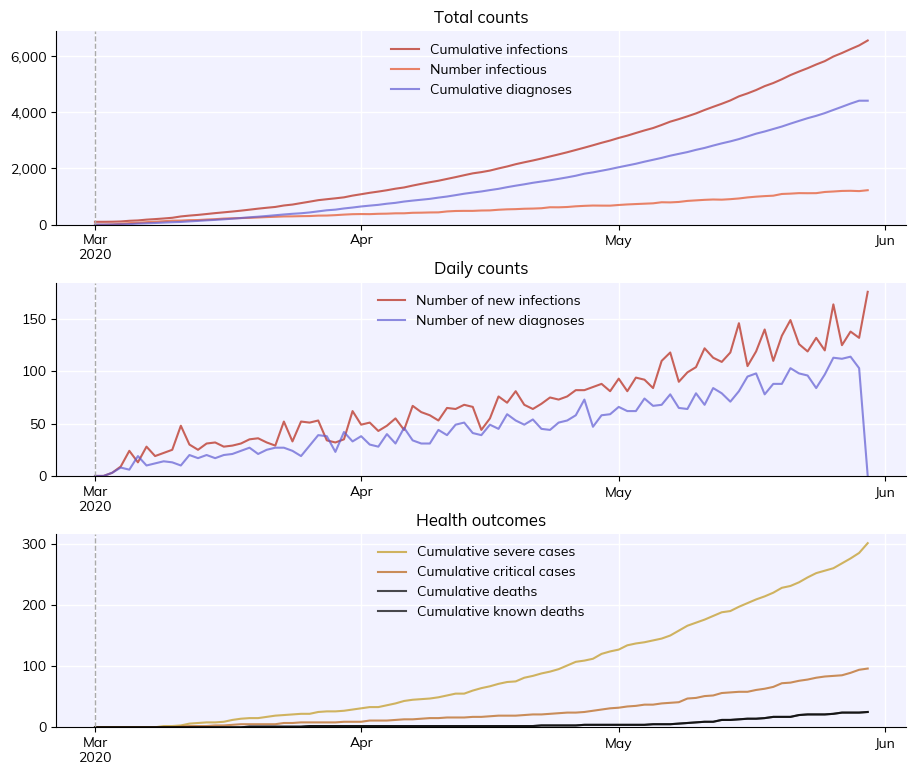

In [48]:
sim_test_run_default()

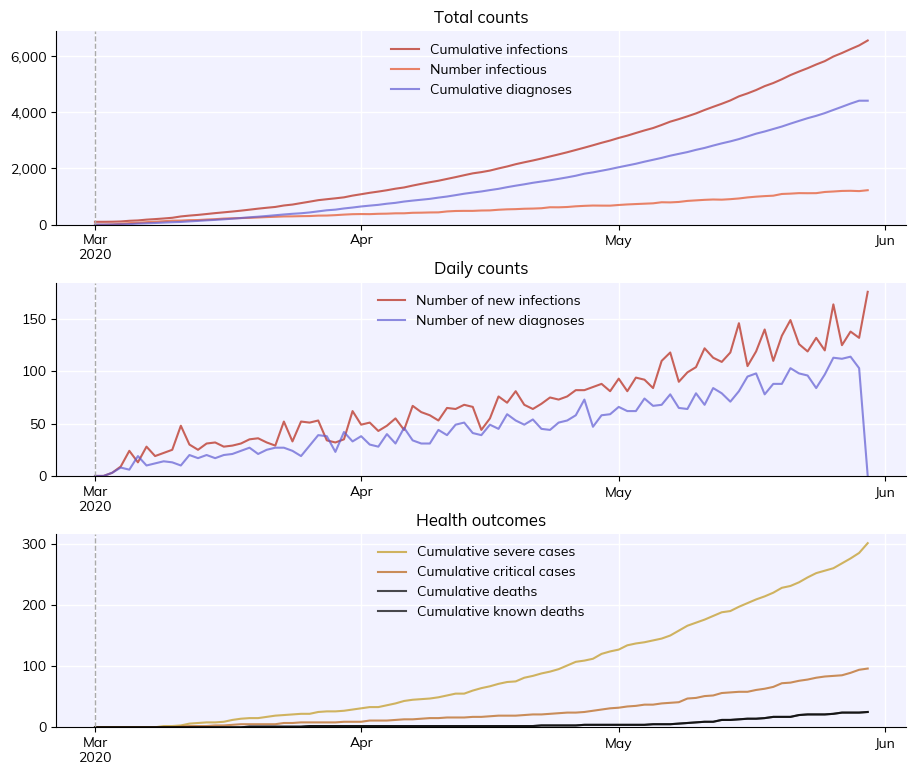

In [49]:
# add in custom test intervention with 0 % nontesters, should be same as above
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.0, FRAC_NONISOLATORS=0.0, FRAC_SXISOLATORS=0.0
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='check default'
)

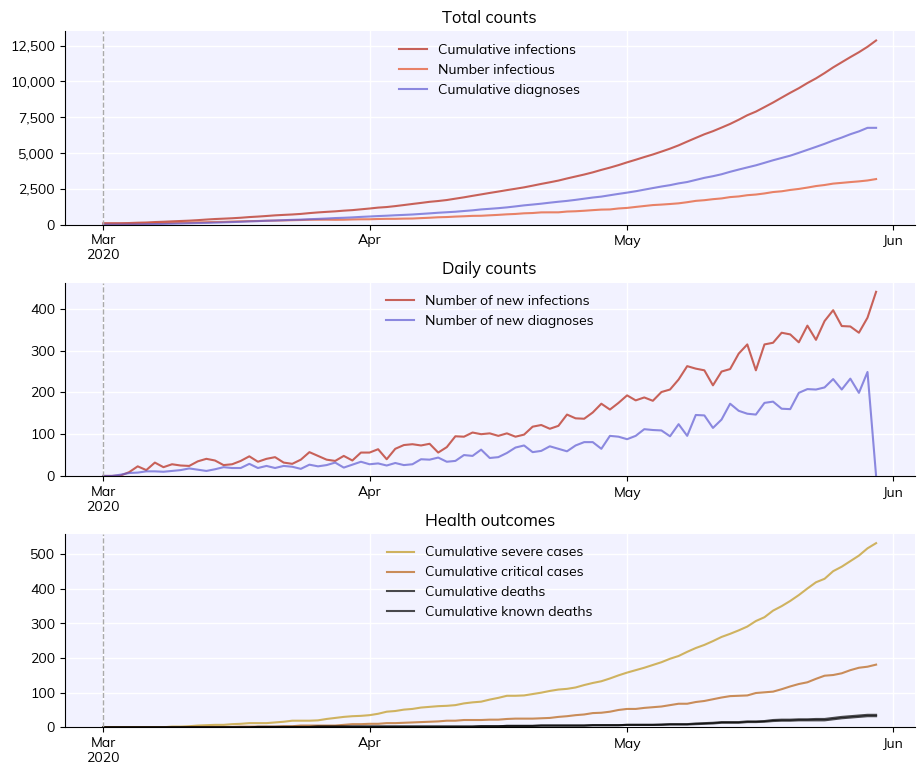

In [50]:
# adding nontesters should result in more infections
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.2, FRAC_NONISOLATORS=0.0, FRAC_SXISOLATORS=0.0
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='20% nontesters'
)

#### handling non-isolators and symptomatic-isolators
* to handle these groups, we modify the check_enter_iso method on **instance** of People class
* note we will modify the method on the People **instance** created for sim (instead of subclassing People **class**)
* TODO: generally, this kind of monkeypatching a method on an instance is discouraged (can make errors hard to find); consider subclassing People, overriding method; however, this would necessitate other changes in covasim code flow

In [51]:
def check_enter_iso_modified(self):
    """Custom fnc to account for sxisolators and nonisolators
    (see https://docs.idmod.org/projects/covasim/en/latest/_modules/covasim/people.html#People.check_enter_iso)
    
    Code changes from original function: addition of 2. and 3. and assertion statements below"""
    
    # here we modify final list of isolated individuals --
    # 1. determine initial list of individuals to isolate (iso inds) in standard way
    iso_inds = cvu.true(self.date_diagnosed == self.t)
    
    # below is from original function
    #self.isolated[iso_inds] = True
    #self.date_end_isolation[iso_inds] = self.date_recovered[iso_inds]
    #return iso_inds

    # 2. find agents that became symptomatic on given date & add sxisolators subset to iso inds
    current_sx = cvu.true((self.date_symptomatic == self.t))
    current_sx_isolators = np.intersect1d(current_sx, self.sxisolators) 
    iso_inds_updated = np.union1d(iso_inds, current_sx_isolators).astype(np.int32) # ensure ints
    
    # 3. remove nonisolators from initial list of iso inds
    iso_inds_updated = np.setdiff1d(iso_inds_updated, self.nonisolators).astype(np.int32) # ensure ints
    
    # TODO: think of a better way to test & move test outside this fnc
    assert set(self.nonisolators).intersection(iso_inds_updated)==set()
    assert set(current_sx_isolators).intersection(iso_inds_updated)==set(current_sx_isolators)

    # 4. from here down, we use new list of iso inds and code from original function
    self.isolated[iso_inds_updated] = True
    self.date_end_isolation[iso_inds_updated] = self.date_recovered[iso_inds_updated]
    return iso_inds_updated


In [52]:
# update run fnc with new capability
def sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label=''
):
    # custom test_num interv
    test_interv = test_num_modified(
        daily_tests=[frac_popn_tested_daily*pop_size]*n_days, # stub instead of using observed daily test nums
    )
    # setup pars
    pars = dict(
        pop_size = pop_size,
        pop_infected = pop_infected,
        n_days = n_days,
        verbose = verbose,
    )
    # setup sim
    sim = cv.Sim(pars, interventions=test_interv, label=label)
    sim.initialize() # initialize people so we can add attributes below
    
    # override the check_enter_iso method on people instance with custom method above
    # see https://stackoverflow.com/questions/394770/override-a-method-at-instance-level,
    # answer from `Mad Physicist`
    sim.people.check_enter_iso = check_enter_iso_modified.__get__(sim.people, cv.People)
    # add in agent partitions
    sim.people.nontesters = nontesters
    sim.people.sxisolators = sxisolators
    sim.people.nonisolators = nonisolators
    
    # now run and plot
    sim.run()
    sim.plot()
    pl.show()
    return


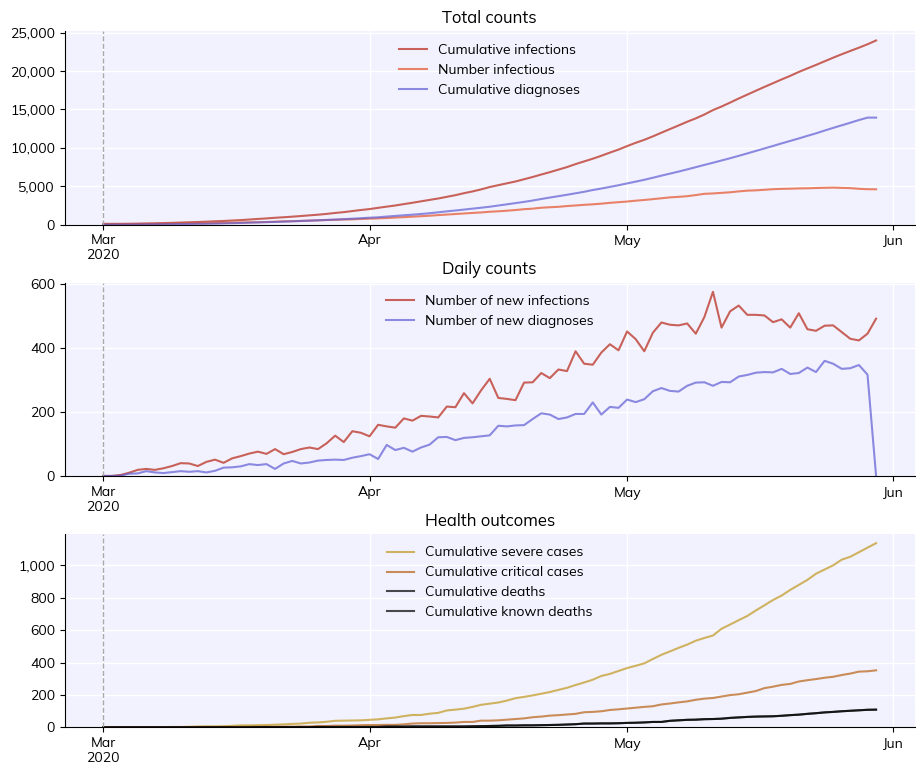

In [53]:
# new baseline
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.0, FRAC_NONISOLATORS=0.0, FRAC_SXISOLATORS=0.0
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.01, # note fewer tests available in these experiments
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='baseline'
)

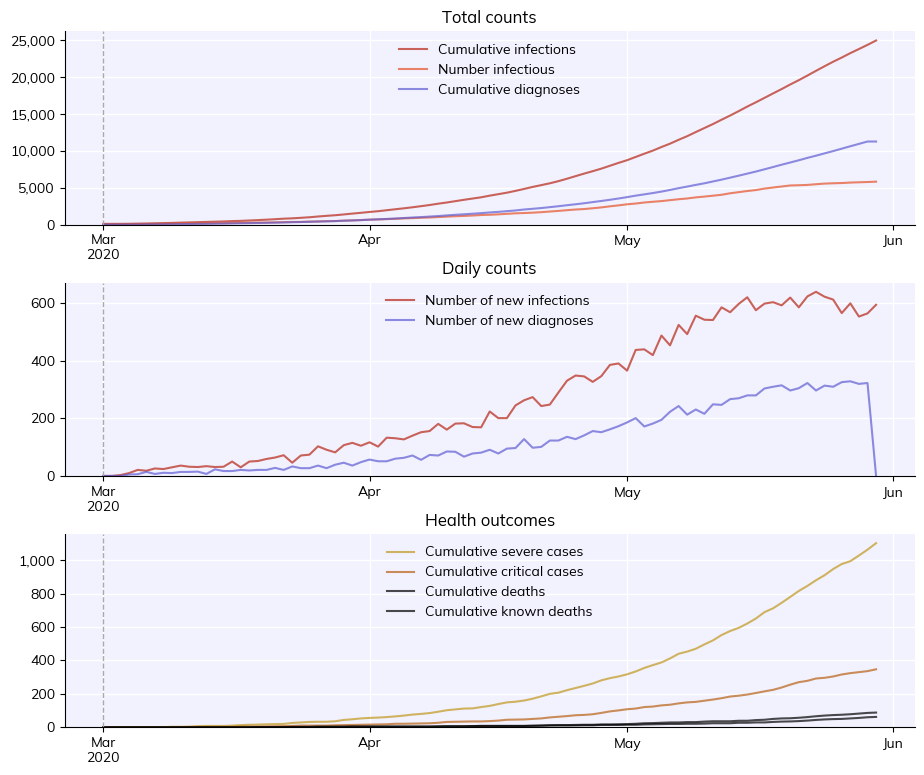

In [54]:
# with nontesters, cumulative infxns goes up a bit & in this case cumulative diagnosed goes down
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.2, FRAC_NONISOLATORS=0.0, FRAC_SXISOLATORS=0.0
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='20% nontesters'
)

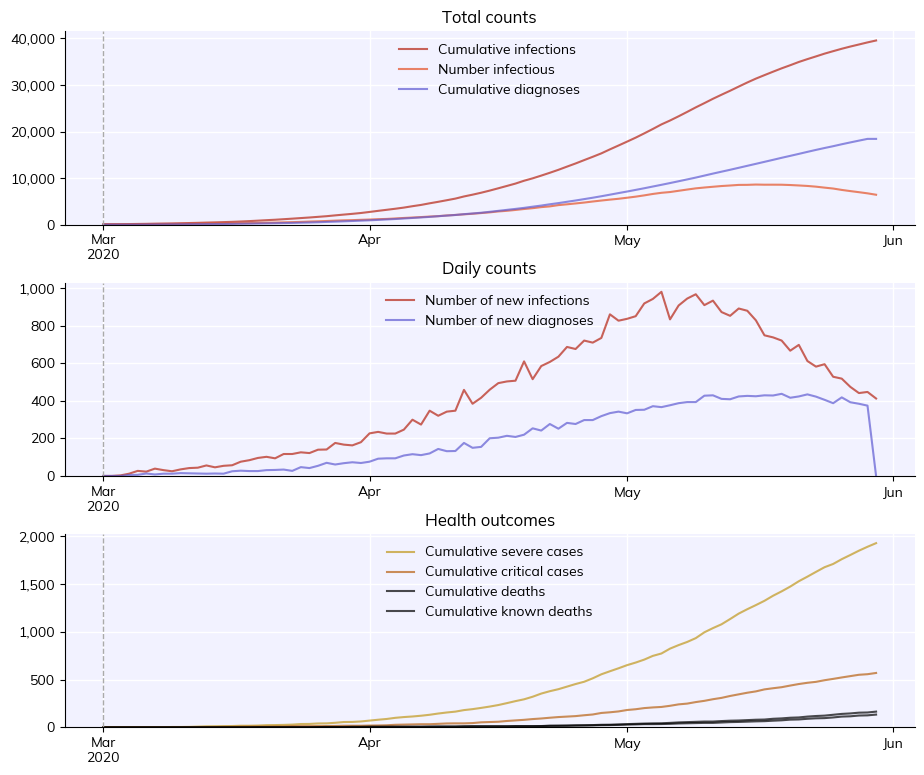

In [55]:
# adding in nonisolators should increase cumulative number infections and diagnoses
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.2, FRAC_NONISOLATORS=0.2, FRAC_SXISOLATORS=0.0
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='20% nontesters & 20% nonisolators'
)

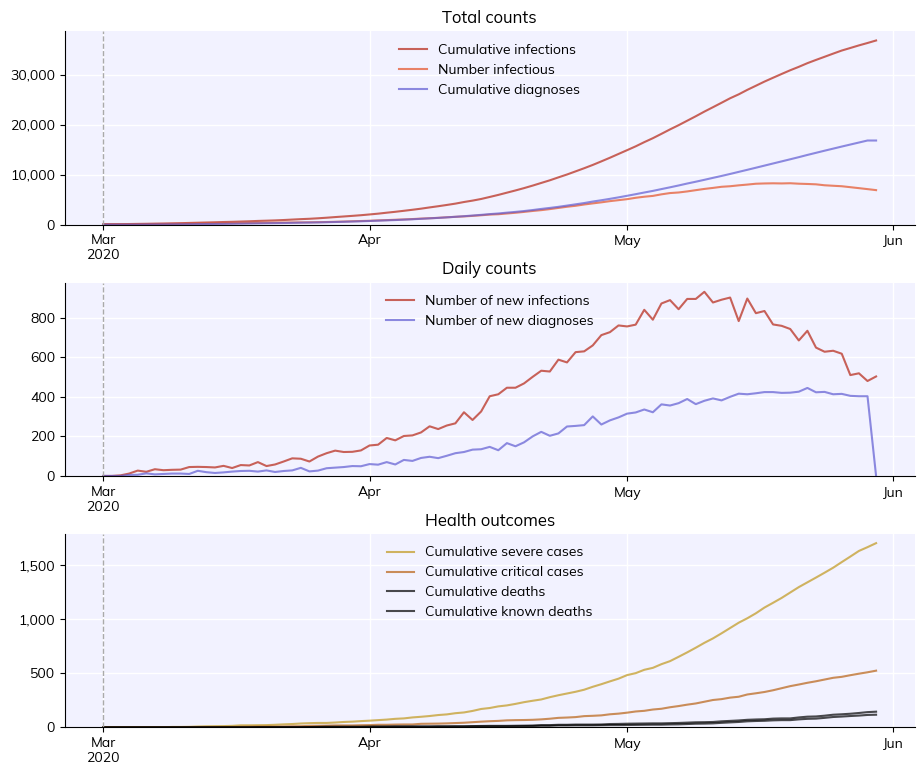

In [56]:
# adding in symptomatic isolators should decrease cumulative number infections and diagnoses
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.2, FRAC_NONISOLATORS=0.2, FRAC_SXISOLATORS=0.2
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='20% nontesters, 20% nonisolators, 20% sxisolators'
)

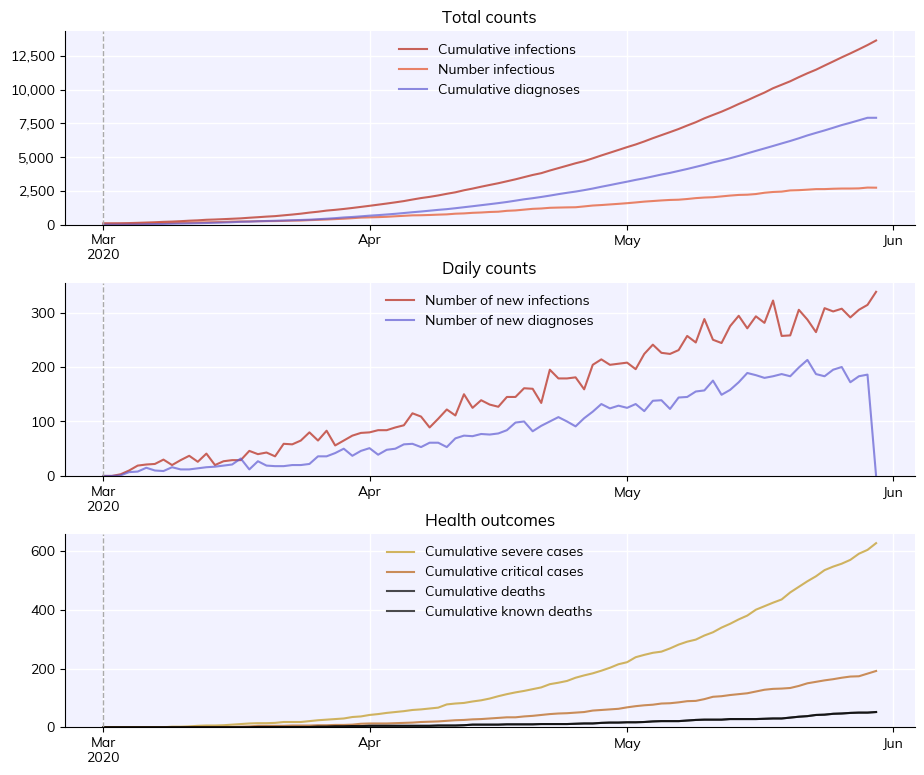

In [57]:
# removing all but symptomatic isolators should decrease cumulative number infections and diagnoses
nontesters, nonisolators, sxisolators, _ = define_subgroups(
    FRAC_NONTESTERS=0.0, FRAC_NONISOLATORS=0.0, FRAC_SXISOLATORS=0.2
)

sim_test_run(
    nontesters, nonisolators, sxisolators,
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='20% sxisolators'
)

#### can we alter the agents in each group over time?
* from Steve: 
    * "the different subgroups it might tricky to nail down data other than surveys, but those might be biased. I think we do have to change it over time, but I think three periods is sufficient a) March lockdowns b) May 2020 through May 2021 c) June 2021 until now. With willingness going down throughout due to pandemic fatigue, etc."
* three periods essentially means agents get partitioned into the 4 groups differently at day0, dayX, and dayY 

In [58]:
def dynamic_agent_partition(
    sim,
    nontester_fracs=[0.0, 0.0],      # fraction of nontesters at each time partition is modified
    nonisolator_fracs=[0.0, 0.0],    # fraction of nonisolators at each time partition is modified
    sxisolator_fracs=[0.0, 0.0],     # fraction of sxisolators at each time partition is modified
    days=[0,45]                      # days on which to modify the partition
):
    """Based on first example under Custom interventions at
    https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_interventions.html"""
    assert len(days)==len(nontester_fracs), f"list of days to change partition must have same len as fractions"
    assert len(days)==len(nonisolator_fracs), f"list of days to change partition must have same len as fractions"
    assert len(days)==len(sxisolator_fracs), f"list of days to change partition must have same len as fractions"
    pop_size = sim.pars['pop_size']
    for i in range(len(days)):
        # if we are on one of the days specified as input, repartition agents &
        # update respective attributes on people instance
        # note: if seed IS NOT changed, the shuffle step to create partitions is same;
        # so, if fractions go down over time, subset of agents will change partitions as follows:
        # nontesters -> nonisolators, nonisolators -> sxisolators, sxisolators -> defaults;
        # if fractions go up over time, movement is in opposite direction;
        # if seed IS changed, the shuffle step to create partitions is different,
        # and thus new partition is created with no relation to prior
        if sim.t == days[i]:
            nontesters, nonisolators, sxisolators, default = define_subgroups(
                pop_size, 
                # setting seed=i provides new seed for each partition, 
                # but these new partitions will be constant across replicate runs;
                # alternatively could set seed as constant, e.g., 314,
                # this would ensure shuffle step is always same, only fractions change
                seed=i,
                FRAC_NONTESTERS=nontester_fracs[i], 
                FRAC_NONISOLATORS=nonisolator_fracs[i],  
                FRAC_SXISOLATORS=sxisolator_fracs[i], 
            )
            sim.people.nontesters = nontesters
            sim.people.sxisolators = sxisolators
            sim.people.nonisolators = nonisolators

    return


In [59]:
# update run fnc with new capability
def sim_test_run(
    dynamic_agent_partition=None,
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label=''
):
    # custom test_num interv
    test_interv = test_num_modified(
        daily_tests=[frac_popn_tested_daily*pop_size]*n_days, # stub instead of using observed daily test nums
    )
    # setup pars
    pars = dict(
        pop_size = pop_size,
        pop_infected = pop_infected,
        n_days = n_days,
        verbose = verbose,
    )
    # setup sim
    sim = cv.Sim(pars, interventions=[dynamic_agent_partition, test_interv], label=label)
    sim.initialize() # initialize people so we can add attributes below
    # override the check_enter_iso method on people instance with custom method above
    sim.people.check_enter_iso = check_enter_iso_modified.__get__(sim.people, cv.People)
    # add in agent partitions
    sim.people.nontesters = nontesters
    sim.people.sxisolators = sxisolators
    sim.people.nonisolators = nonisolators
    # now run and plot
    sim.run()
    sim.plot()
    pl.show()
    return


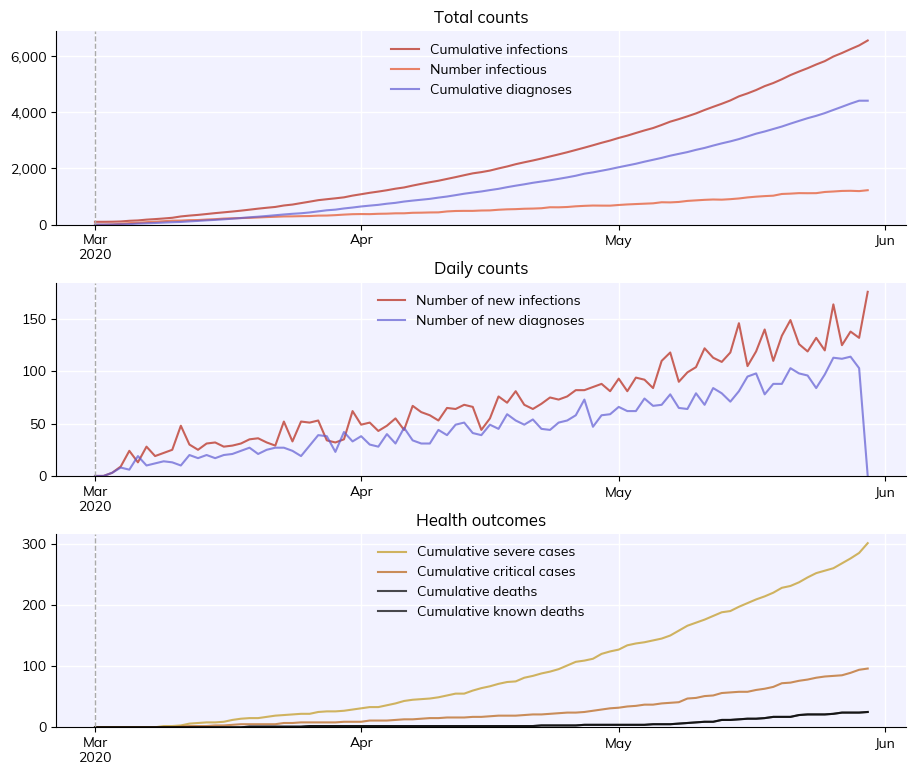

In [60]:
#### baseline: a litte more than 6k cumulative infections
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.0, 0.0],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents: baseline'
)

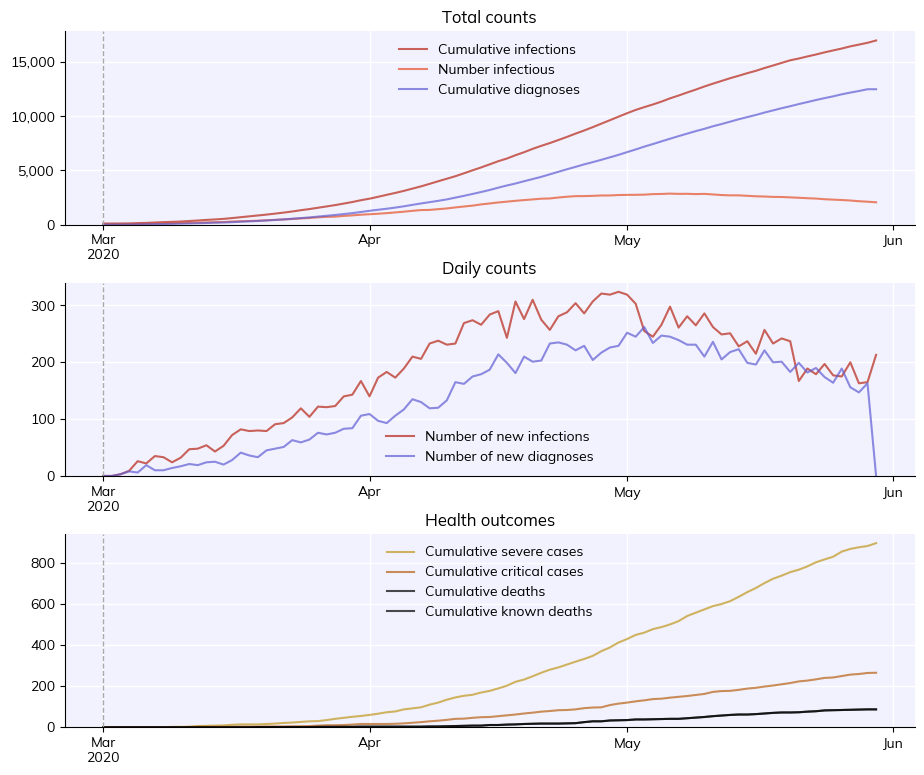

In [61]:
# here and 2 cells below: nonisolators in 1st time block, 2nd time block, both time blocks
# results are ~16k, 12.5k, 25k cum INFECTIONS at end of sim
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.3, 0.0]
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 30% nonisolators in first time block'
)

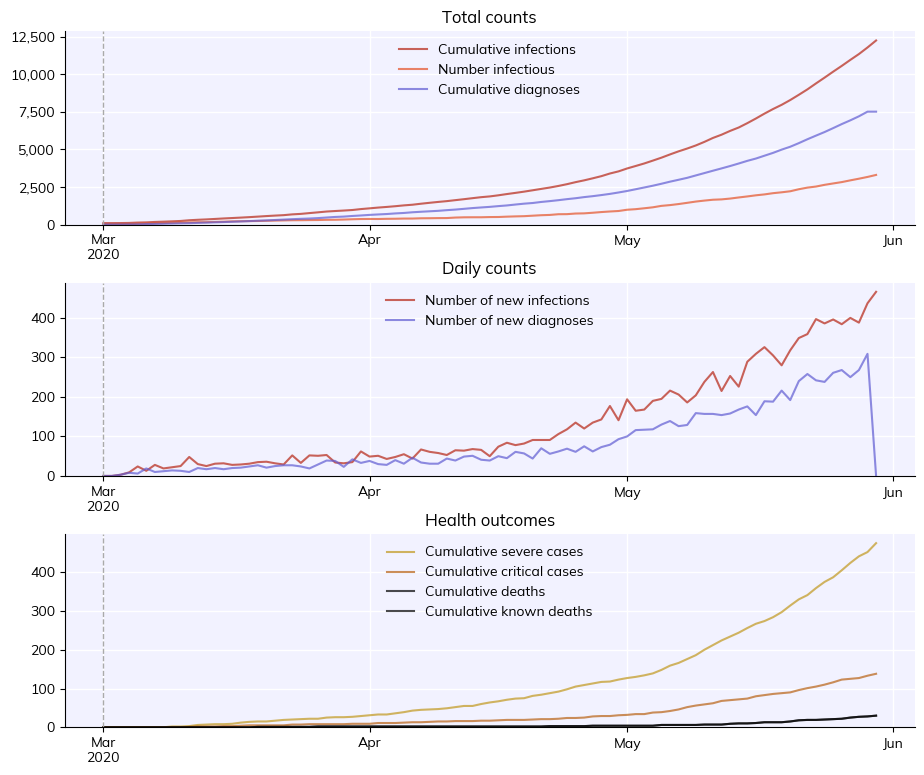

In [62]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.0, 0.3]
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 30% nonisolators in second block'
)

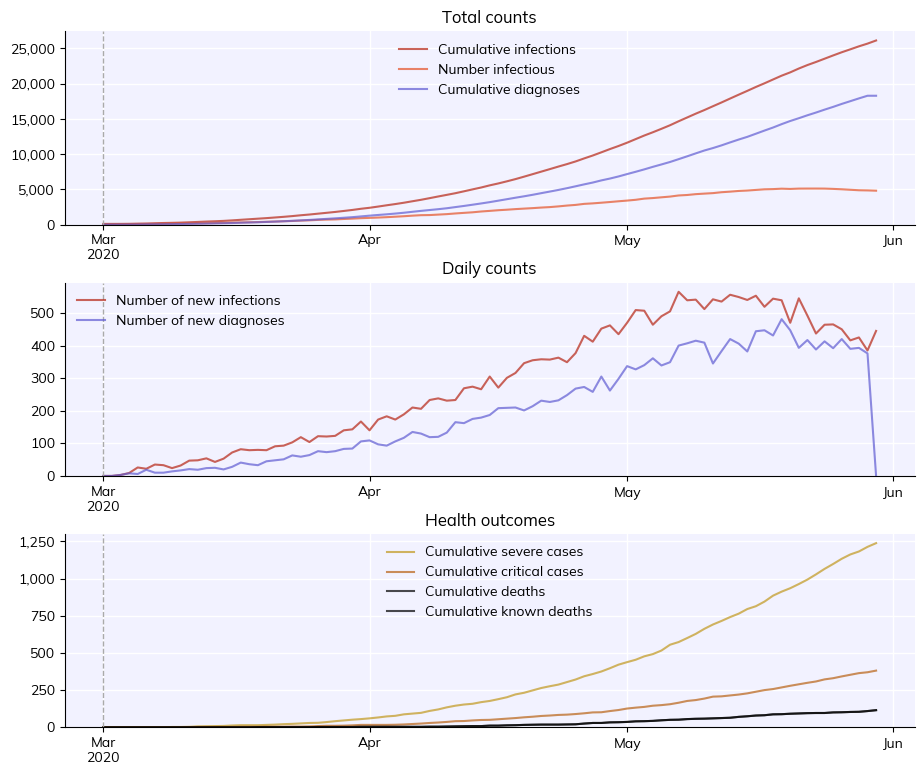

In [63]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.3, 0.3]
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 30% nonisolators in both blocks'
)

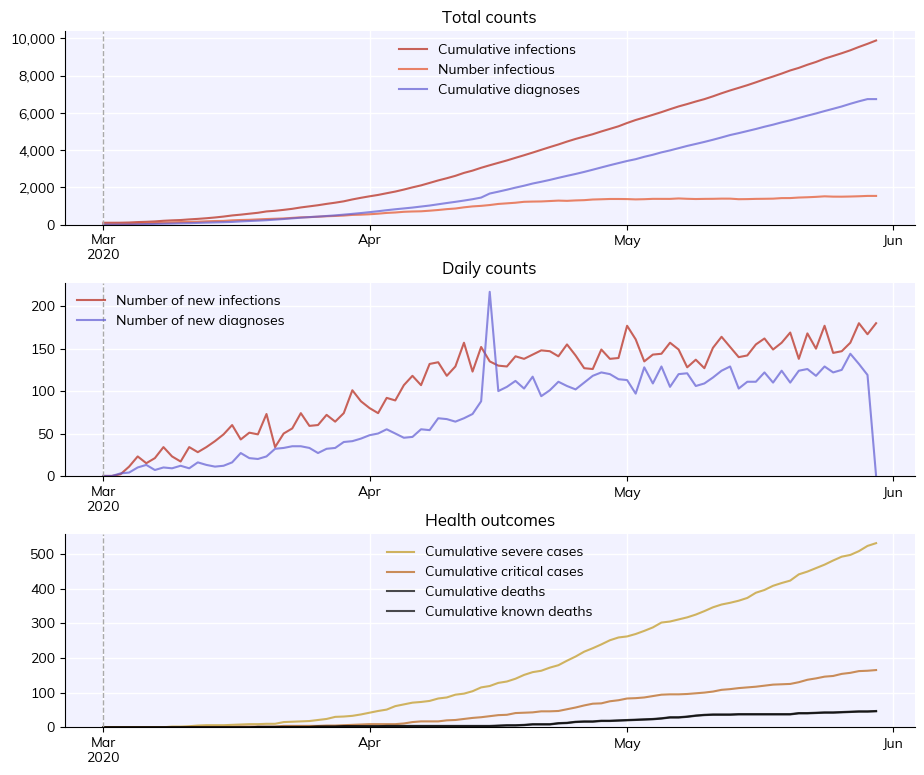

In [64]:
# here and 2 cells below: nontesters in 1st time block, 2nd time block, both time blocks
# results are ~7k, 5.5k cum DIAGNOSES at end of sim, 
# and 15k cum INFECTIONS at end of sim for 3rd case (up from 10k) 
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nontester_fracs=[0.2, 0.0],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents: 20% nontesters in first block'
)

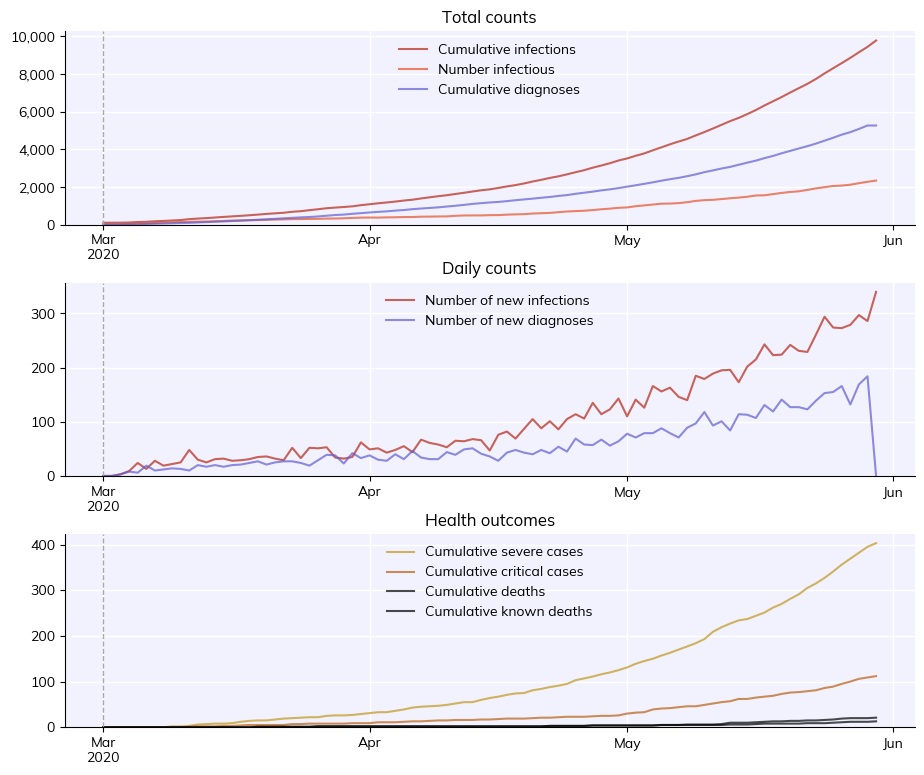

In [65]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nontester_fracs=[0.0, 0.2],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 20% nontesters in second block'
)

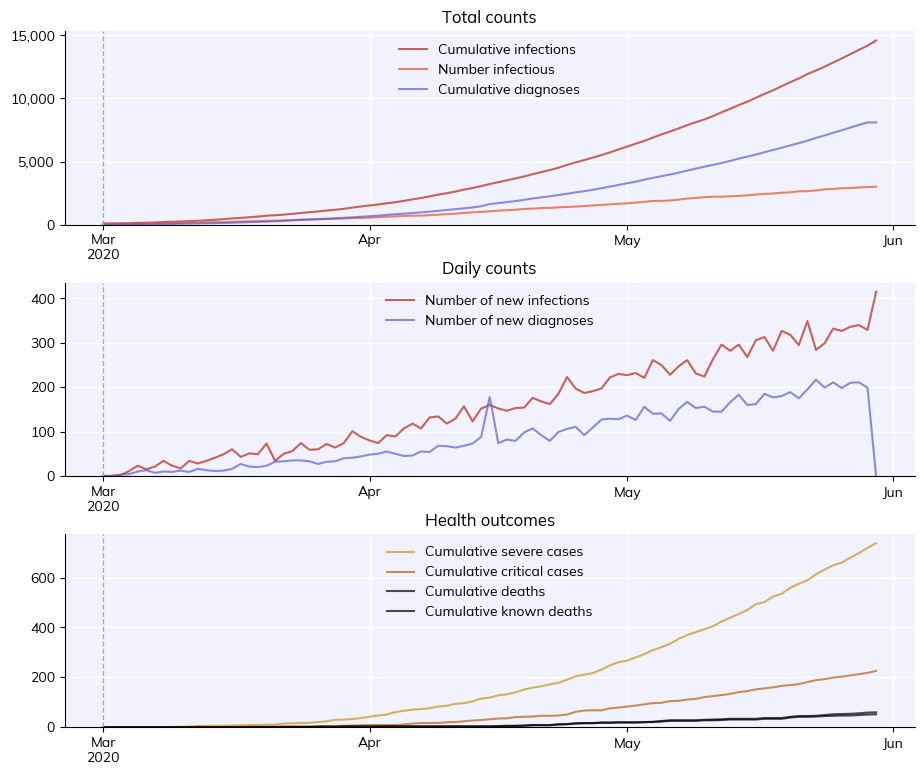

In [66]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nontester_fracs=[0.2, 0.2],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 20% nontesters in both blocks'
)

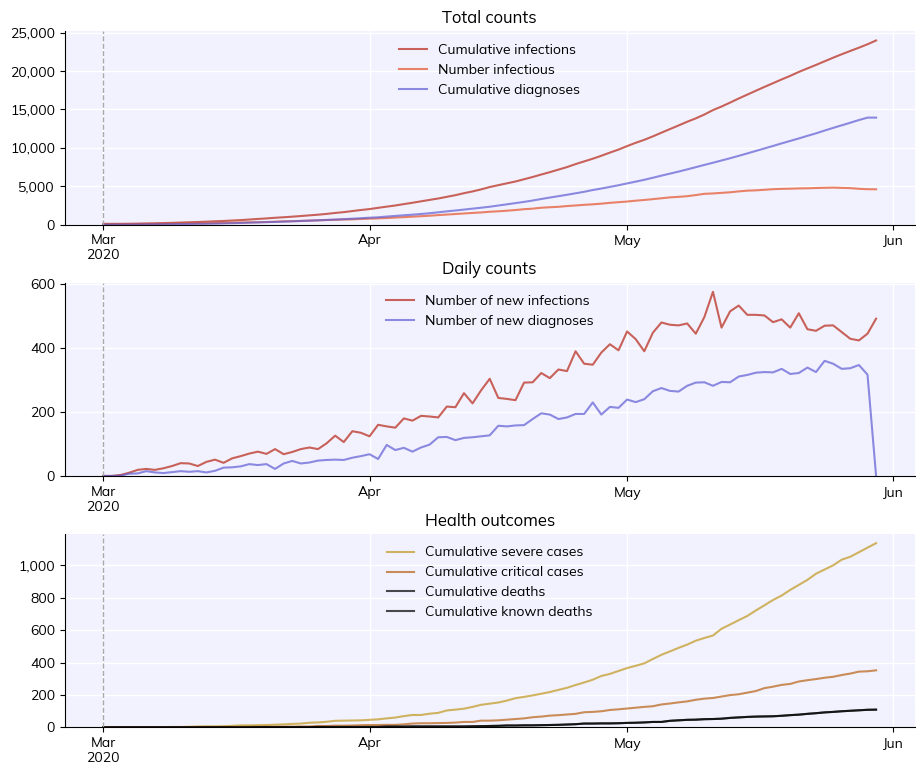

In [67]:
# now for sxisolators...first, run new baseline
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        sxisolator_fracs=[0.0, 0.0],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, new baseline'
)

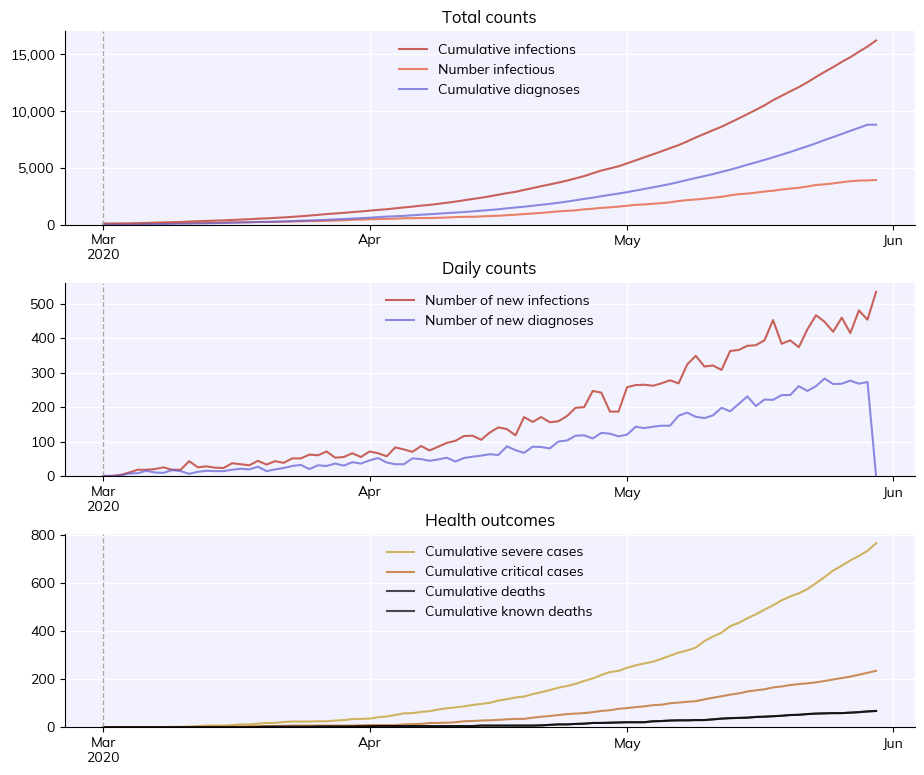

In [68]:
# here and 2 cells below: sxisolators in 1st time block, 2nd time block, both time blocks
# results are ~15-16k, 17k, 12.5k cum INFECTIONS at end of sim
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        sxisolator_fracs=[0.8, 0.0],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 80% symptomatic isolators in first block'
)

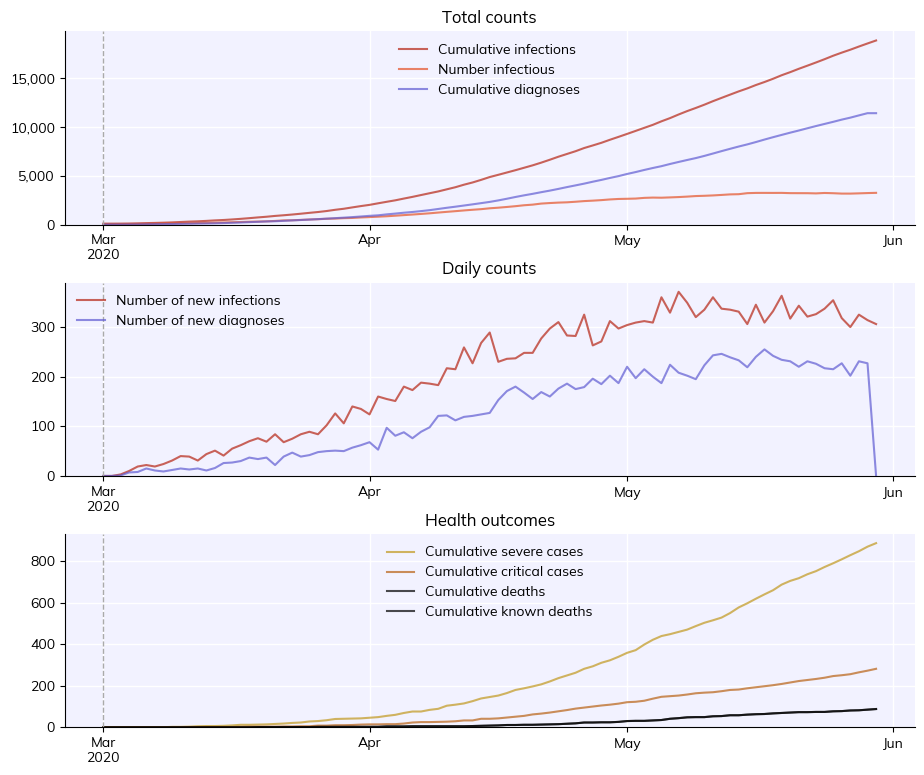

In [69]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        sxisolator_fracs=[0.0, 0.8],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 80% symptomatic isolators in second block'
)

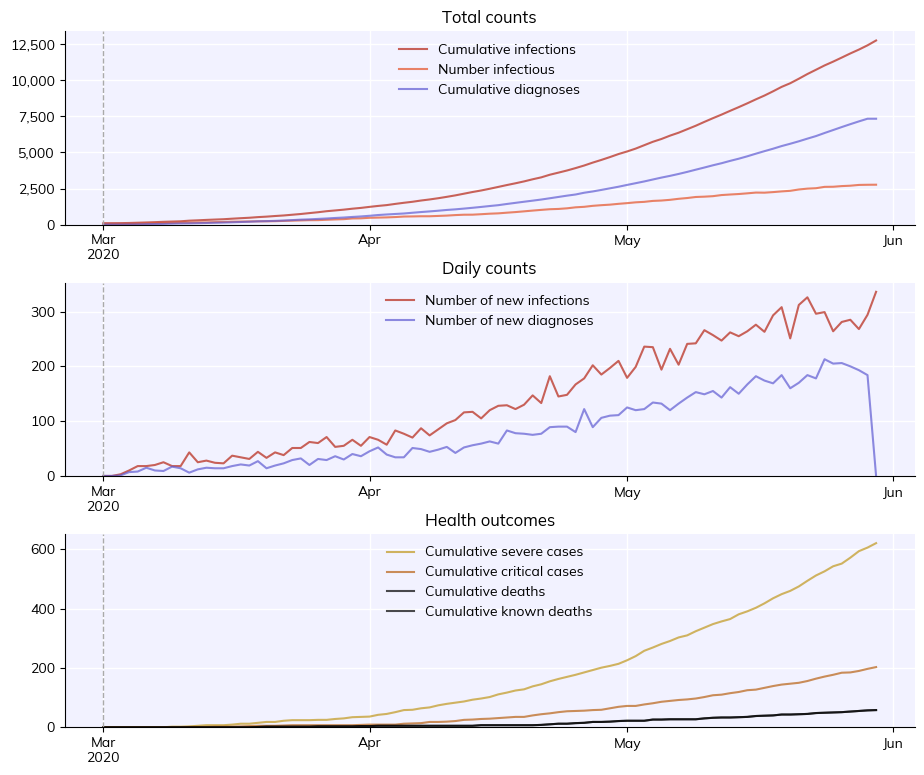

In [70]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        sxisolator_fracs=[0.8, 0.8],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, 80% symptomatic isolators in both blocks'
)

#### upshot of all the above
* dynamic partitioning of sxisolators, nontesters, nonisolators across sim seems to work as expected

#### demo all together

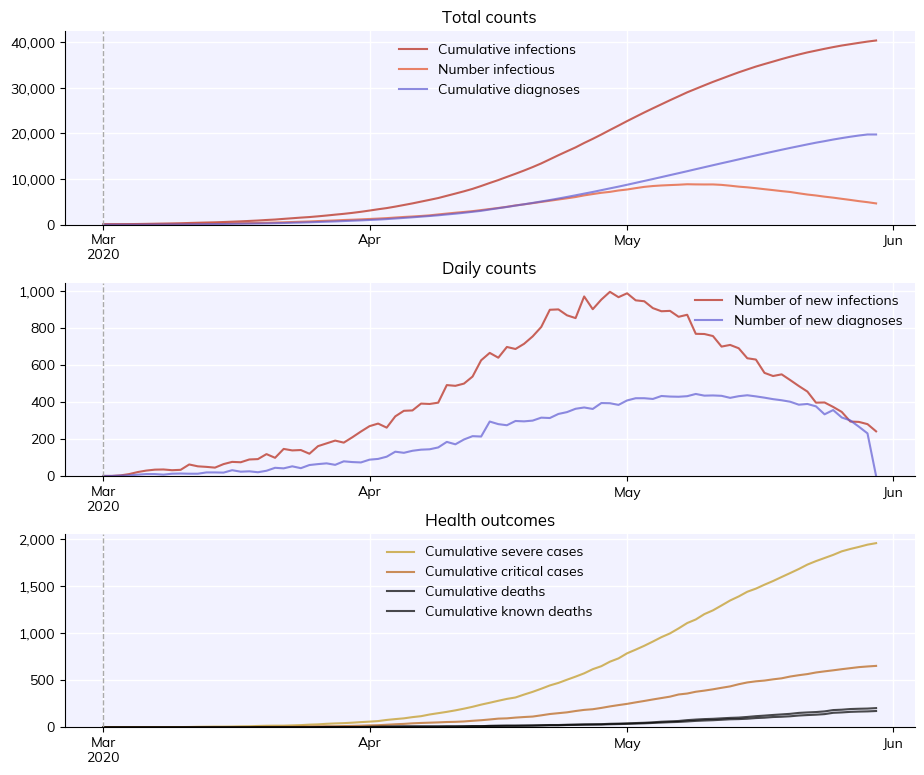

In [71]:
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.3, 0.3],
        nontester_fracs=[0.2, 0.2],
        sxisolator_fracs=[0.3, 0.3],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='dynamic partition agents, all together'
)

#### modify contact tracing so that nontesters / nonisolators do not change their behavior

In [72]:
class contact_tracing_modified(cv.Intervention):
    """
    Create custom intervention that is slight tweak of original covasim contact_tracing intervention
    (see https://docs.idmod.org/projects/covasim/en/latest/_modules/covasim/interventions.html#contact_tracing).
    Only change is: we do not notify any nontesters / nonisolators of any sick contacts. We want to
    ensure these agents do NOT change behavior in response to contact tracing -- simplest way to enforce
    seems to be 'just do not notify them'.
    
    As with original contact_tracing intervention, without testing, contact tracing has no effect.
    
    Only changes from original contact_tracing intervention are lines with '##' comment just above. 
    TODO: consider subclassing covasim.interventions.contact_tracing & overriding 'notify_contacts' method
    """
    
    def __init__(self, trace_probs=None, trace_time=None, start_day=0, end_day=None, presumptive=False, quar_period=None, capacity=None, **kwargs):
        super().__init__(**kwargs) # Initialize the Intervention object
        self.trace_probs = trace_probs
        self.trace_time  = trace_time
        self.start_day   = start_day
        self.end_day     = end_day
        self.presumptive = presumptive
        self.capacity = capacity
        self.quar_period = quar_period # If quar_period is None, it will be drawn from sim.pars at initialization
        return


    def initialize(self, sim):
        ''' Process the dates and dictionaries '''
        super().initialize()
        self.start_day = preprocess_day(self.start_day, sim)
        self.end_day   = preprocess_day(self.end_day,   sim)
        self.days      = [self.start_day, self.end_day]
        if self.trace_probs is None:
            self.trace_probs = 1.0
        if self.trace_time is None:
            self.trace_time = 0.0
        if self.quar_period is None:
            self.quar_period = sim['quar_period']
        if sc.isnumber(self.trace_probs):
            val = self.trace_probs
            self.trace_probs = {k:val for k in sim.people.layer_keys()}
        if sc.isnumber(self.trace_time):
            val = self.trace_time
            self.trace_time = {k:val for k in sim.people.layer_keys()}
        return


    def apply(self, sim):
        '''
        Trace and notify contacts

        Tracing involves three steps that can independently be overloaded or extended
        by derived classes

        - Select which confirmed cases get interviewed by contact tracers
        - Identify the contacts of the confirmed case
        - Notify those contacts that they have been exposed and need to take some action
        '''
        t = sim.t
        start_day = get_day(self.start_day, self, sim)
        end_day   = get_day(self.end_day,   self, sim)
        if t < start_day:
            return
        elif end_day is not None and t > end_day:
            return

        trace_inds = self.select_cases(sim)
        contacts = self.identify_contacts(sim, trace_inds)
        self.notify_contacts(sim, contacts)
        return contacts


    def select_cases(self, sim):
        '''
        Return people to be traced at this time step
        '''
        if not self.presumptive:
            inds = cvu.true(sim.people.date_diagnosed == sim.t) # Diagnosed this time step, time to trace
        else:
            just_tested = cvu.true(sim.people.date_tested == sim.t) # Tested this time step, time to trace
            inds = cvu.itruei(sim.people.exposed, just_tested) # This is necessary to avoid infinite chains of asymptomatic testing

        # If there is a tracing capacity constraint, limit the number of agents that can be traced
        if self.capacity is not None:
            capacity = int(self.capacity / sim.rescale_vec[sim.t])  # Convert capacity into a number of agents
            if len(inds) > capacity:
                inds = np.random.choice(inds, capacity, replace=False)

        return inds


    def identify_contacts(self, sim, trace_inds):
        '''
        Return contacts to notify by trace time

        In the base class, the trace time is the same per-layer, but derived classes might
        provide different functionality e.g. sampling the trace time from a distribution. The
        return value of this method is a dict keyed by trace time so that the `Person` object
        can be easily updated in `contact_tracing.notify_contacts`

        Args:
            sim: Simulation object
            trace_inds: Indices of people to trace

        Returns: {trace_time: np.array(inds)} dictionary storing which people to notify
        '''

        if not len(trace_inds):
            return {}

        contacts = sc.ddict(list)

        for lkey, this_trace_prob in self.trace_probs.items():

            if this_trace_prob == 0:
                continue

            traceable_inds = sim.people.contacts[lkey].find_contacts(trace_inds)
            if len(traceable_inds):
                contacts[self.trace_time[lkey]].extend(cvu.binomial_filter(this_trace_prob, traceable_inds)) # Filter the indices according to the probability of being able to trace this layer

        array_contacts = {}
        for trace_time, inds in contacts.items():
            array_contacts[trace_time] = np.fromiter(inds, dtype=cvd.default_int)

        return array_contacts


    def notify_contacts(self, sim, contacts):
        '''
        Notify contacts

        This method represents notifying people that they have had contact with a confirmed case.
        In this base class, that involves

        - Setting the 'known_contact' flag and recording the 'date_known_contact'
        - Scheduling quarantine

        Args:
            sim: Simulation object
            contacts: {trace_time: np.array(inds)} dictionary storing which people to notify
        '''
        is_dead = cvu.true(sim.people.dead) # Find people who are not alive
        for trace_time, contact_inds in contacts.items():
            contact_inds = np.setdiff1d(contact_inds, is_dead) # Do not notify contacts who are dead
            
            ## DO NOT NOTIFY CONTACTS WHO ARE NONISOLATORS / NONTESTERS
            ## (THESE GUYS WILL NOT CHANGE BEHAVIOR IF CONTACT TRACED; SO JUST ENFORCE THIS BY
            ## NOT NOTIFYING THEM) -- comment these lines out to experiment with this intervention
            contact_inds = np.setdiff1d(contact_inds, sim.people.nonisolators).astype(np.int32) # ensure ints
            contact_inds = np.setdiff1d(contact_inds, sim.people.nontesters).astype(np.int32) # ensure ints
            
            sim.people.known_contact[contact_inds] = True
            sim.people.date_known_contact[contact_inds] = np.fmin(sim.people.date_known_contact[contact_inds], sim.t + trace_time)
            sim.people.schedule_quarantine(contact_inds, start_date=sim.t + trace_time, period=self.quar_period - trace_time)  # Schedule quarantine for the notified people to start on the date they will be notified
        return
    
    

In [73]:
# update run fnc with new capability
def sim_test_run(
    dynamic_agent_partition=None,
    pop_size=50e3,
    frac_popn_tested_daily=0.05,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='',
    use_modified_contact_tracing=False
):
    # custom test_num interv
    test_interv = test_num_modified(
        daily_tests=[frac_popn_tested_daily*pop_size]*n_days, # stub instead of using observed daily test nums
    )
    # contact trace interv
    if use_modified_contact_tracing:
        # custom contact_tracing interv
        contact_trace = contact_tracing_modified(
            trace_probs=0.5 #can also use: dict(h=1.0, s=0.5, w=0.5, c=0.3)
        )
    else:
        # standard contact tract interv
        contact_trace = cv.contact_tracing(
            trace_probs=0.5 #can also use: dict(h=1.0, s=0.5, w=0.5, c=0.3)
        )
    # setup pars
    pars = dict(
        pop_size = pop_size,
        pop_infected = pop_infected,
        n_days = n_days,
        verbose = verbose,
    )
    
    # setup sim
    sim = cv.Sim(pars, interventions=[dynamic_agent_partition, test_interv, contact_trace], label=label)
    sim.initialize() # initialize people so we can add attributes below
    # override the check_enter_iso method on people instance with custom method above
    sim.people.check_enter_iso = check_enter_iso_modified.__get__(sim.people, cv.People)
    # add in agent partitions
    sim.people.nontesters = nontesters
    sim.people.sxisolators = sxisolators
    sim.people.nonisolators = nonisolators
    # now run and plot
    sim.run()
    sim.plot()
    #sim.plot(['new_infections', 'new_tests', 'new_diagnoses', 'cum_diagnoses', 'new_quarantined', 'test_yield'])
    pl.show()
    return 


c:\Users\ling1\Anaconda3\lib\site-packages\covasim\sim.py:449: RuntimeWarning: 
Note: you have defined a contact tracing intervention but no testing intervention was found. Unless this is intentional, please define at least one testing intervention.
  cvm.warn(warnmsg)


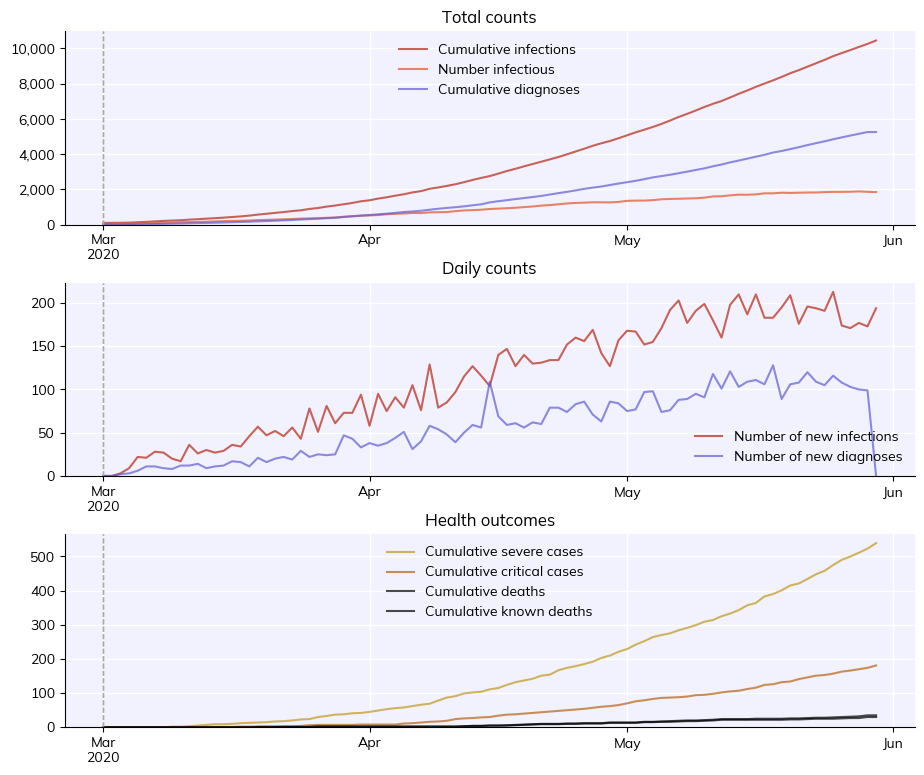

In [74]:
# if we use usual contact trace intervention (contact tracing for all), cumul infxns ~ 10k
sim = sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.3, 0.3],
        nontester_fracs=[0.2, 0.2],
        sxisolator_fracs=[0.3, 0.3],
        days=[0,45]
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='usual contact tracing',
    use_modified_contact_tracing=False
)

# note: warning below comes from covasim.sim, Sim class, init_interventions method, not a concern...
# there IS a testing intervention, despite the warning, it is just not detected
# because test_num_modified is not an instance of cv.test_num or cv.test_prob...
# it should go away, if test_num_modified is refactored to subclass cv.test_num...
# can verify it is working by setting dynamic partition fractions to 0, 
# compare results with cv.test_num to those with test_num_modified (get same results)

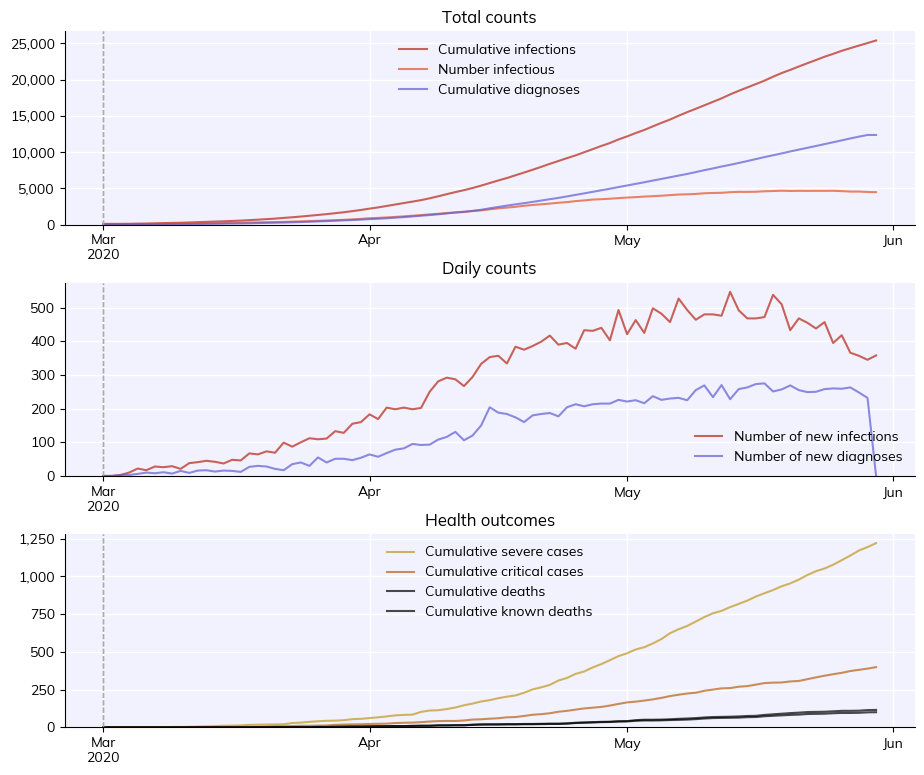

In [75]:
# with modified contact tracing (no effect on nonisolators, nontesters), cumul infxns ~ 25k
sim_test_run(
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nonisolator_fracs=[0.3, 0.3],
        nontester_fracs=[0.2, 0.2],
        sxisolator_fracs=[0.3, 0.3],
    ),
    pop_size=50e3,
    frac_popn_tested_daily=0.01,
    pop_infected=100,
    n_days=90,
    verbose=0,
    label='modified contact tracing',
    use_modified_contact_tracing=True
)
# here there is no warning because contact_tracing_modified is not an instance of cv.contact_tracing

#### what does this look like for our actual sims?
* below we add above modifications to a version of our actual script for running ABM
* note this version is not the 'real version' (see msim.py for real version)
* essentially we add in our custom modifications:
    * dynamic_agent_partition
    * test_num_modified
    * contact_tracing_modified
    * check_enter_iso_modified

In [76]:
# a lot of these already imported, just repeat for completeness
import datetime, math, os, pathlib, sys
from collections import Counter

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter

import sciris as sc
import covasim as cv
import covasim.parameters as cvp


# task_id = sys.argv[1]

print("imports succeeded...")


imports succeeded...


In [77]:
class store_doses(cv.Analyzer):
    # see https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_analyzers.html
    # this is just a way to capture info on vaccinations during sim
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = []
        self.n_complete_primary = []
        return

    def apply(self, sim):
        ppl = sim.people # Shorthand
        self.t.append(sim.t)
        # see boosters tutorial
        # https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_immunity.html
        self.n_complete_primary.append((ppl.doses >= 2).sum())
        return

    def plot(self):
        plt.figure()
        plt.plot(self.t, self.n_complete_primary, label='completed primary series')
        plt.legend()
        plt.ylabel('people')
        sc.setylim() # Reset y-axis to start at 0
        sc.commaticks() # Use commas in the y-axis labels
        return
    
    
class store_nab(cv.Analyzer):
    # see https://docs.idmod.org/projects/covasim/en/latest/tutorials/tut_analyzers.html
    # this is a way to capture info on neutralizing antibodies in simulated population
    # these come from either 1) prior infection or 2) vaccination
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = []
        self.daily_nabs = []
        self.ct_ppl_nabs = []
        return

    def apply(self, sim):
        ppl = sim.people # Shorthand
        self.t.append(sim.t)
        nonzero = ppl.nab > 0
        self.daily_nabs.append(ppl.nab.sum())
        self.ct_ppl_nabs.append(nonzero.sum())
        return

    def plot(self):
        plt.figure()
        plt.plot(self.t, self.daily_nabs, label='sum nabs')
        plt.legend()
        plt.ylabel('nabs')
        sc.setylim() # Reset y-axis to start at 0
        sc.commaticks() # Use commas in the y-axis labels
        return
    
    

def load_daily_vax_doses(mappers_path):
    # function to load dicts that map date to number vax doses
    [dt2pfizer_primary, dt2moderna_primary, dt2janssen_primary, dt2boost] = joblib.load(mappers_path)
    
    # sanity checks: for this to work, need our dates (keys) to be strings
    assert type(list(dt2pfizer_primary.keys())[0]) == type('foo')
    assert type(list(dt2boost.keys())[0]) == type('foo')
    
    # also make sure that dicts do not return NaNs
    for ix, d in enumerate([
        dt2pfizer_primary, dt2moderna_primary, dt2janssen_primary, dt2boost
    ]):
        for k, v in d.items():
            if math.isnan(v):
                print(k,v)
                break
                
    return dt2pfizer_primary, dt2moderna_primary, dt2janssen_primary, dt2boost




* below we set up actual sim
* the custom interventions / changes made above are incorporated below
    * marked by "## NEW INTERV"

In [78]:
def make_sim(
    seed, beta, data_path, mappers_path,
    N_AGENTS = 100e3,
    people_per_agent = 1, 
    start_day = '2020-01-20',
    end_day='2022-03-01', 
    verbose=0,
    analyzers=[],
    pop_infected=10,
    dynamic_agent_partition=dynamic_agent_partition,
):

    # set parameter vals / rename using covasim varnames
    #total_pop    = 330e6 # ~ US population size
    pop_type     = 'hybrid'
    pop_size     = N_AGENTS # "pop_size" actually refers to number of agents in sim
    pop_scale    = people_per_agent # int(total_pop/pop_size)
    asymp_factor = 1                                       # Multiply beta by this factor for asymptomatic cases
    # contacts     = {'h':2.0, 's':20, 'w':16, 'c':20}     # defaults for contacts / layer are overwritten with data for 'usa'
    
    # check on sim being initialized
    print(f"simulating {N_AGENTS=}, {people_per_agent=}, total popn {N_AGENTS * people_per_agent}")
    print(f"using data from {data_path}")
    print(f"using daily vax doses from {mappers_path}")
    
    # load vax per day data
    dt2pfizer_primary, dt2moderna_primary, dt2janssen_primary, dt2boost = load_daily_vax_doses(mappers_path)
      
    # make dict for instantiating sim object
    pars = sc.objdict(
        use_waning   = True,
        pop_size     = pop_size,     # =N_AGENTS, input parameter
        pop_infected = pop_infected, # input parameter, 1000 usually
        pop_scale    = pop_scale,    # =people_per_agent, input parameter
        pop_type     = pop_type,     # 'hybrid'
        start_day    = start_day,    # input parameter, 2020-01-20 usually
        end_day      = end_day,      # input parameter, 2022-03-01 usually
        beta         = beta,         # input parameter ~ 0.0079-0.01
        asymp_factor = asymp_factor, # set above, 
        # contacts     = contacts,   # instead, use defaults for 'usa': {'h': 1.491, 's': 20, 'w': 16, 'c': 20} 
        rescale      = True,
        rand_seed    = seed,
        verbose      = verbose,
    )

    # instantiate sim object
    sim = cv.Sim(pars=pars, datafile=data_path, location='usa', analyzers=analyzers)

    # MASKING / DISTANCING::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    # this dict has dates as keys, vals are list of relative transmissibility in 4 settings:
    # home, school, work, community; initial "data/theoretically derived" values are in comments
    # to the right, lines with no comment have been added
    t = pd.read_csv('model_files/param.soc.csv')
    beta_past = sc.odict(dict(zip(t['date'], t.iloc[:,1:-1].values.tolist())))
    print(f"social params:\n{beta_past}")

    beta_dict = beta_past
    beta_days = list(beta_dict.keys())
    h_beta = cv.change_beta(days=beta_days, changes=[c[0] for c in beta_dict.values()], layers='h')
    s_beta = cv.change_beta(days=beta_days, changes=[c[1] for c in beta_dict.values()], layers='s')
    w_beta = cv.change_beta(days=beta_days, changes=[c[2] for c in beta_dict.values()], layers='w')
    c_beta = cv.change_beta(days=beta_days, changes=[c[3] for c in beta_dict.values()], layers='c')
    
    interventions = [h_beta, w_beta, s_beta, c_beta]
    # MASKING / DISTANCING::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    
    # DYNAMIC AGENT PARTITIONING::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    ## NEW INTERV
    dynamic_agent_partition=partial(
        dynamic_agent_partition, 
        nontester_fracs=[0.0, 0.05, 0.2],
        nonisolator_fracs=[0.0, 0.02, 0.1],
        sxisolator_fracs=[0.0, 0.3, 0.2],
        # change agent partition on these days: ('2020-01-20', '2020-05-01', '2021-05-01'), 
        # can verify by checking sim.date(0), sim.date(102), sim.date(467)
        days=[0, 102, 467],  
    )
    interventions += [dynamic_agent_partition]
    # DYNAMIC AGENT PARTITIONING::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

    # TESTING/CONTACT TRACING:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    # we use actual number of reported tests and defaults for relative transmissibility changes
    # here are isolation / quarantine factors for 'hybrid' popn
    # iso_factor  = dict(h=0.3, s=0.1, w=0.1, c=0.1),  # Multiply beta by this factor for people in isolation
    # quar_factor = dict(h=0.6, s=0.2, w=0.2, c=0.2),  # Multiply beta by this factor for people in quarantine
    # assumed quarantine factor=0.3
    ## NEW INTERV
    testing = test_num_modified(
        daily_tests='data',
        sensitivity=0.85    ## change from default 1.0
    )
    
    ## NEW INTERV
    contact_trace = contact_tracing_modified(
        trace_probs=dict(h=1.0, s=0.3, w=0.2, c=0.1), 
        trace_time=dict(h=0, s=2, w=3, c=5),
        do_plot=False
    )
    
    ## optionally reset iso_factor / quar_factor from defaults for home / school / work / community
    sim.pars['iso_factor'] = dict(h=0.3, s=0.1, w=0.1, c=0.1)
    sim.pars['quar_factor'] = dict(h=0.6, s=0.2, w=0.2, c=0.2)
    
    interventions += [testing, contact_trace]
    # TESTING/CONTACT TRACING:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    
    # VACCINES::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    # we use actual number of reported vaccinations, defaults are in 
    # covasim.parameters.get_vaccine_variant_pars()
    # first make vaccine specific dicts with params, this essentially just adds info for omicron for
    # the 3 different vaccines
    dose_pars = cvp.get_vaccine_dose_pars()['pfizer']
    variant_pars = cvp.get_vaccine_variant_pars()['pfizer']
    variant_pars['omicron'] = 0.1 # 0.8, some but not much protection from primary series
    variant_pars['label'] = 'pfizer-vax'
    pfizer_vaccine = sc.mergedicts({'label':'pfizer_us'}, sc.mergedicts(dose_pars, variant_pars))

    dose_pars = cvp.get_vaccine_dose_pars()['moderna']
    variant_pars = cvp.get_vaccine_variant_pars()['moderna']
    variant_pars['omicron'] = 0.1 # 0.8
    variant_pars['label'] = 'moderna-vax'
    moderna_vaccine = sc.mergedicts({'label':'moderna_us'}, sc.mergedicts(dose_pars, variant_pars))

    dose_pars = cvp.get_vaccine_dose_pars()['jj']
    variant_pars = cvp.get_vaccine_variant_pars()['jj']
    variant_pars['omicron'] = 0.1 # 0.8
    variant_pars['label'] = 'jj-vax'
    jj_vaccine = sc.mergedicts({'label':'jj_us'}, sc.mergedicts(dose_pars, variant_pars)) 
    
    # these functions take date and return number of primary doses vaccine for that date by mfr
    def num_doses_pfizer(sim):
        return int(dt2pfizer_primary.get(sim.date(sim.t), 0))

    def num_doses_moderna(sim):
        return int(dt2moderna_primary.get(sim.date(sim.t), 0))

    def num_doses_janssen(sim):
        return int(dt2janssen_primary.get(sim.date(sim.t), 0))

    # make primary vaccine interventions
    pfizer = cv.vaccinate_num(
        vaccine=pfizer_vaccine, sequence='age', num_doses=num_doses_pfizer,
    )
    moderna = cv.vaccinate_num(
        vaccine=moderna_vaccine, sequence='age', num_doses=num_doses_moderna,
    )
    jj = cv.vaccinate_num(
        vaccine=jj_vaccine, sequence='age', num_doses=num_doses_janssen
    )
    interventions += [pfizer, moderna, jj]
    
    # this function takes date and returns number of booster doses for that date
    def num_boosters(sim):
        return int(dt2boost.get(sim.date(sim.t), 0))
    
    # target boosters to people who have had 2 prior doses of vaccine
    booster_target  = {'inds': lambda sim: cv.true(sim.people.doses != 2), 'vals': 0}
    
    # as an approximation, assume all boosters are pfizer -- update omicron param
    dose_pars = cvp.get_vaccine_dose_pars()['pfizer']
    variant_pars = cvp.get_vaccine_variant_pars()['pfizer']
    variant_pars['omicron'] = 0.34 #0.5
    variant_pars['label'] = 'pfizer-boost'
    pfizer_vaccine_boost = sc.mergedicts({'label':'pfizer_us'}, sc.mergedicts(dose_pars, variant_pars))
    
    # make booster intervention
    pfizer_boost = cv.vaccinate_num(
       vaccine=pfizer_vaccine_boost, sequence='age', booster=True, num_doses=num_boosters,
       subtarget=booster_target, 
    )
    interventions += [pfizer_boost]
    # VACCINES::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    
    # VARIANTS::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    # for simplicity, we model wild type, alpha, delta, omicron thru 3/1/2022 
    # see https://www.medrxiv.org/content/10.1101/2021.12.28.21268491v2.full#F2, Figure 2E for potential
    # parameters on immunity from prior infection, vaccine
    var_param_names = [
        'rel_beta', 'rel_symp_prob', 'rel_severe_prob', 'rel_crit_prob', 'rel_death_prob'
    ]
    v = pd.read_csv('model_files/param.var.csv')
    print(f"variant params:\n{v.T}")
    assert v.iloc[0,0]=='wildtype'
    assert v.iloc[1,0]=='alpha'
    assert v.iloc[2,0]=='delta'
    assert v.iloc[3,0]=='omicron'
    wt = v.iloc[0,1:].values
    al = v.iloc[1,1:].values
    de = v.iloc[2,1:].values
    om = v.iloc[3,1:].values
    
    # adjust hosp, critical, deaths from wildtype here
    for ix, feat in enumerate(var_param_names):
        sim.pars[feat] = wt[ix]
        
    # first wt wave handled through pop_infected parameter (=1000 at beginning of sim)
        
    # second wt wave ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    wt2 = cv.variant(
        label='wild-type-wave2',
        n_imports=3300*100/5,
        days=np.array([
            sim.day('2020-06-01'),sim.day('2020-06-02'),sim.day('2020-06-03'),sim.day('2020-06-04'),sim.day('2020-06-05'),
        ]),
        variant={
            var_param_names[i]: wt[i] for i in range(len(var_param_names))
        }
    )
    wt2.rescale = True
    sim['variants'] += [wt2]
    # second wt wave ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    
    # third wt wave ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    wt3 = cv.variant(
        label='wild-type-wave3',
        n_imports=3300*100/5,
        days=np.array([
            sim.day('2020-10-15'),sim.day('2020-10-16'),sim.day('2020-10-17'),sim.day('2020-10-18'),sim.day('2020-10-19'),
            sim.day('2020-10-20'),sim.day('2020-10-21'),sim.day('2020-10-22'),sim.day('2020-10-23'),sim.day('2020-10-24'),
        ]),
        variant={
            var_param_names[i]: wt[i] for i in range(len(var_param_names))
        }
    )
    wt3.rescale = True
    sim['variants'] += [wt3]
    # third wt wave ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

    # Alpha strain from October 2020; n_imports, rel_beta and rel_severe_beta from calibration
    # Alpha: Dec 21 2020 – Jun 21 2021
    alpha = cv.variant(
        'alpha', 
        n_imports=3300*100/5,  
        days=np.array([
            sim.day('2020-12-28'),sim.day('2020-12-29'),sim.day('2020-12-30'),sim.day('2020-12-31'),sim.day('2021-01-01'), 
        ]), 
    )
    alpha.rescale = True
    for ix, feat in enumerate(var_param_names):
        alpha.p[feat] = al[ix]
    sim['variants'] += [alpha]
    
    # Delta strain starting middle of April 2021; n_imports, rel_beta and rel_severe_beta from calibration
    # Delta: Apr 12 2021 – Feb 14 2022
    delta = cv.variant(
        'delta', 
        n_imports=3300*100/10,
        days=np.array([
            sim.day('2021-04-10'),sim.day('2021-04-11'),sim.day('2021-04-12'),sim.day('2021-04-13'),sim.day('2021-04-14'),
            sim.day('2021-04-15'),sim.day('2021-04-16'),sim.day('2021-04-17'),sim.day('2021-04-18'),sim.day('2021-04-19'),
        ]), 
    )
    delta.rescale = True
    for ix, feat in enumerate(var_param_names):
        delta.p[feat] = de[ix]
    sim['variants'] += [delta]
    
    # Add Omicron strain starting middle of Nov 2021; n_imports, rel_beta and rel_severe_beta from calibration
    # Omicron: Dec 6 2021 – Mar 28 2022
    omicron = cv.variant(
        label='omicron', 
        n_imports=3300*100/10,
        days=np.array([
            sim.day('2021-11-26'),sim.day('2021-11-27'),sim.day('2021-11-28'),#sim.day('2021-11-29'),sim.day('2021-11-30'),
            #sim.day('2021-12-01'),sim.day('2021-12-02'),sim.day('2021-12-03'),sim.day('2021-12-04'),sim.day('2021-12-05'),
        ]), 
        variant={
            var_param_names[i]: om[i] for i in range(len(var_param_names))
        }
    )
    omicron.rescale = True
    sim['variants'] += [omicron]
    # VARIANTS::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    

    # add daily age stats analyzer
    analyzers += [cv.daily_age_stats(edges= [0, 30,  65,  80, 100])]
    analyzers += [cv.nab_histogram(days=['2020-07-01', '2021-01-01', '2021-07-01', '2022-01-01'], label='hist')]
    analyzers += [store_nab(label='nab')]

    # update parameters, add analyzers
    sim.update_pars(interventions=interventions, analyzers=analyzers)

    # if desired, change death and critical probabilities, example below
    # interventions += [cv.dynamic_pars({'rel_death_prob':{'days':sim.day('2020-07-01'), 'vals':0.6}})]
    # update the parameters
    # sim.update_pars(interventions=interventions)
    
    # turn off intervention plotting
    for intervention in sim['interventions']:
        intervention.do_plot = False

    sim.initialize()
    
    ## NEW INTERV
    ## override the check_enter_iso method on people instance with custom method above
    sim.people.check_enter_iso = check_enter_iso_modified.__get__(sim.people, cv.People)
    
    # display the variant params
    var_param_names = [
        'rel_beta', 'rel_symp_prob', 'rel_severe_prob', 'rel_crit_prob', 'rel_death_prob'
    ]

    return sim


In [79]:
def custom_plot(msim, outfile=None):
    # custom plotting fnc for  cum / new infections, diagnoses, hospitalizations, deaths, and by variant
    font = {'family' : 'Mulish',
            #'weight' : 'bold',
            'size'   : 12}

    matplotlib.rc('font', **font)

    fig, ax_list = plt.subplots(5, 2)
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(20, 20)

    for_plot = [
        ['cum_infections', 'new_infections'],
        ['cum_diagnoses', 'new_diagnoses'],
        ['cum_severe', 'new_severe'],
        ['cum_deaths', 'new_deaths'],
        ['cum_infections_by_variant', 'new_infections_by_variant']
    ]

    feat2color = {
        'cum_infections':'red', 'new_infections':'red',
        'cum_diagnoses':'blue', 'new_diagnoses':'blue',
        'cum_severe':'orange', 'new_severe':'orange',
        'cum_deaths':'black', 'new_deaths':'black'
    }

    has_data = [
        'cum_diagnoses', 'new_diagnoses',
        'cum_severe', 'new_severe',
        'cum_deaths', 'new_deaths'
    ]

    feat2label = {
        'cum_infections':'cumulative infections, model', 'new_infections':'new infections, model',
        'cum_diagnoses':'cumulative diagnoses, model', 'new_diagnoses':'new diagnoses, model',
        'cum_severe':'cumulative hospitalizations, model', 'new_severe':'new hospitalizations, model',
        'cum_deaths':'cumulative deaths, model', 'new_deaths':'new deaths, model'
    }

    xtick_labels = ['Jan\n2020', 'Apr', 'Jul', 'Oct', 'Jan\n2021', 'Apr', 'Jul', 'Oct', 'Jan\n2022', 'Apr']

    for row_ix, row in enumerate(ax_list):
        for col_ix, ax in enumerate(row):
            # create basic plot
            feature = for_plot[row_ix][col_ix]

            # if this feature is variant specific ...
            if feature in msim.results['variant'].keys():
                varcol = [
                    ('wild type', '#91B5DA'), ('wild type2', '#91B5DA'), ('wild type3', '#91B5DA'), 
                    ('alpha', '#E74D52'), 
                    ('delta', '#74BE75'), ('omicron', '#B575B1')
                ]
                for j in range(len(varcol)):
                    (variant, color) = varcol[j]
                    ax.plot(
                        msim.results['date'], msim.results['variant'][feature][j], 
                        color=color, label=variant
                    )
                    ax.fill_between(
                        msim.results['date'], 
                        msim.results['variant'][feature].low[j], 
                        msim.results['variant'][feature].high[j], 
                        alpha=.2,
                        color=color
                    )        
            # if the feature is not variant specific...
            else:
                # ISSUE OF CUMULATIVE CURVES -- DATA AND MODEL PREDICTIONS
                # RATIONALE: we have no hosp data until 7/21/2020, data on death prior to July seems suspect (weird initial rapid spike in April 2020),
                # overall potential concerning issues with accuracy / reporting until about July 20, 2020 (?)...
                # thus fitting model to these early data may not be helpful & if we just ignore the early data, our curves will be "off" by a constant amount even with perfect model;
                # so we "rebase" cumulative curves to 0 on 7/20/2020 for both model predictions and for data (when/if there are values prior to that date)
                # IMPLICATION: final cumulative data numbers for 3/1/2022 will be "off" due to rebasing (can recover original numbers)
                # METHOD: generally make 7/21/2020 the 'first day' of nonzero values for data & model predictions, this means 'subtracting off' constant values
                # from 7/20/2020 for multiple features / curves; use max operator and zero to avoid negative values (i.e., ensure min value is 0 and not negative)
                # cum_severe: first non-zero hospitalization data is on 7/21/2020 -> subtract off model predictions for cum hosp from 7/20/2020 (676385)
                # cum_diagnoses: subtract off model predictions for cum diag from 7/20/2020, subtract off data for cum diag from 7/20/2020
                # cum_deaths: subtract off model predictions for cum death from 7/20/2020, subtract off data for cum death from 7/20/2020
                # the day index of 7/20/2020 is 182
                assert msim.results['date'][182] == datetime.date(2020, 7, 20)
                # because we start our DATA plots at date index 2 (1/22/2020), we drop index 182 back by 2 to 180
                dt_idx = 180 # this is index for date we use to derive subtract off values
                
                # initialize subtract off values (these will stay 0 for any 'non-cumulative' feature)
                model_subtract_off, data_subtract_off = 0, 0
                
                if feature == 'cum_severe' or feature == 'cum_deaths' or feature == 'cum_diagnoses':
                    # index 181 corresponds to 7/20
                    model_subtract_off = msim.results[feature].values[dt_idx]
                    data_subtract_off = msim.sims[0].data[feature].values[dt_idx]
                    if np.isnan(data_subtract_off):
                        data_subtract_off = 0
                    #print(feature, model_subtract_off, data_subtract_off)
                    #assert model_subtract_off > 0
                    #assert data_subtract_off > 0
                
                color = feat2color[feature]
                label = feat2label[feature]
                # plot model predictions
                ax.plot(
                    msim.results['date'], 
                    # msim.results[feature].values
                    np.maximum(msim.results[feature].values-model_subtract_off, 0),
                    color=color, 
                    label=label
                )
                # plot upper and lower support intervals
                ax.fill_between(
                    msim.results['date'], 
                    #msim.results[feature].low,
                    np.maximum(msim.results[feature].low-model_subtract_off, 0),
                    #msim.results[feature].high, 
                    np.maximum(msim.results[feature].high-model_subtract_off, 0),
                    alpha=.2,
                    color=color
                )
                # plot actual data
                if feature in has_data:
                    ax.scatter( 
                        # the owid data starts on 1/22/2020, 2 days after our sim start of 1/20/2020
                        # so when we plot 'real data' -- that is taken from a frame that starts on
                        # second day of sim; so we start dates at index 2 (1/22/2020)
                        # and instead of 772 days (771 day transitions), we have 770 days of data
                        # from 1/22/2020 to 3/1/2022
                        msim.results['date'][2+dt_idx:], 
                        msim.sims[0].data[feature].values[dt_idx:770]-data_subtract_off,
                        color=color,
                        label=label.replace('model', 'data'),
                        s=5
                    )

            # set xtick labels, format as needed
            ticks_loc = ax.get_xticks().tolist()
            ax.set_xticks(ax.get_xticks().tolist())
            ax.set_xticklabels(xtick_labels, rotation=0, ha='center')

            # turn off scientific notation on y-axis
            ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

            # set color, grid
            ax.set_facecolor("#F2F2FF")
            ax.grid(visible=True, color='white')

            ax.set_ylim(0)
            ax.legend(loc='upper left', fontsize='small', framealpha=0)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.15,
                        hspace=0.4)

    if outfile is not None:
        outfile = outfile.replace('.png', '')
        plt.savefig(f'figs/{outfile}.png', dpi=100, bbox_inches='tight')
    plt.show();
    
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    

In [80]:
# test run of baseline sim with all interventions, 100k agents & 3300 persons per agent
# note: this is just ONE RUN, no replicates here, so no "support intervals" in fig
# this takes ~2min on mac laptop
# analyzer for neutralizing antibodies (nabs) added
s0 = make_sim(
    beta=0.016, 
    pop_infected=1000, #1000,
    N_AGENTS=100_000, #100_000,
    people_per_agent=3300, #3300,
    start_day='2020-01-20',
    end_day='2022-03-01', 
    seed=30, # this gets changed for each replicate
    data_path='data/usa-data-1.0-1.0.csv',
    mappers_path='data/mappers-1.0.joblib',
    verbose=0.1, 
    analyzers=[store_doses(label='doses')]
)

print("made s0...")

task_id = 0 ## tmp fix

s0['rand_seed'] = task_id
s0.set_seed()
s0.label = f"Sim_{task_id}"
print(f"set s0 rand seed to {task_id}...")

s0.run()

# although we only did one replicate above, we make a multisim object from that
# just so we can plot results
msim0 = cv.MultiSim([s0])
msim0.mean()

custom_plot(msim0)

simulating N_AGENTS=100000, people_per_agent=3300, total popn 330000000
using data from data/usa-data-1.0-1.0.csv
using daily vax doses from data/mappers-1.0.joblib
  Automatically adding cumulative column cum_diagnoses_raw from new_diagnoses_raw
  Automatically adding cumulative column cum_deaths_raw from new_deaths_raw
  Automatically adding cumulative column cum_tests from new_tests
social params:
#0: '2020-01-22': [1.1, 1.2, 1.2, 1.0]
#1: '2020-02-11': [1.1, 1.2, 1.1, 1.0]
#2: '2020-03-05': [1.1, 0.3, 1.0, 1.0]
#3: '2020-03-12': [1.1, 0.3, 0.9, 0.9]
#4: '2020-03-14': [1.1, 0.3, 0.8, 0.8]
#5: '2020-03-16': [1.1, 0.3, 0.6, 0.6]
#6: '2020-03-21': [1.1, 0.3, 0.4, 0.4]
#7: '2020-04-01': [1.1, 0.3, 0.3, 0.3]
#8: '2020-06-01': [1.2, 0.2, 0.6, 0.6]
#9: '2020-06-15': [1.2, 0.2, 0.7, 0.7]
#10: '2020-07-20': [1.1, 0.2, 0.8, 0.8]
#11: '2020-08-16': [1.3, 0.3, 0.7, 0.7]
#12: '2020-10-01': [1.5, 0.3, 0.9, 1.0]
#13: '2020-11-01': [1.5, 0.3, 1.0, 1.0]
#14: '2020-11-16': [1.5, 0.4, 1.0, 1.0]
#15: '

simulating N_AGENTS=100000, people_per_agent=3300, total popn 330000000
using data from data/usa-data-1.0-0.2.csv
using daily vax doses from data/mappers-1.0.joblib
  Automatically adding cumulative column cum_diagnoses_raw from new_diagnoses_raw
  Automatically adding cumulative column cum_deaths_raw from new_deaths_raw
  Automatically adding cumulative column cum_tests from new_tests
social params:
#0: '2020-01-22': [1.1, 1.2, 1.2, 1.0]
#1: '2020-02-11': [1.1, 1.2, 1.1, 1.0]
#2: '2020-03-05': [1.1, 0.3, 1.0, 1.0]
#3: '2020-03-12': [1.1, 0.3, 0.9, 0.9]
#4: '2020-03-14': [1.1, 0.3, 0.8, 0.8]
#5: '2020-03-16': [1.1, 0.3, 0.6, 0.6]
#6: '2020-03-21': [1.1, 0.3, 0.4, 0.4]
#7: '2020-04-01': [1.1, 0.3, 0.3, 0.3]
#8: '2020-06-01': [1.2, 0.2, 0.6, 0.6]
#9: '2020-06-15': [1.2, 0.2, 0.7, 0.7]
#10: '2020-07-20': [1.1, 0.2, 0.8, 0.8]
#11: '2020-08-16': [1.3, 0.3, 0.7, 0.7]
#12: '2020-10-01': [1.5, 0.3, 0.9, 1.0]
#13: '2020-11-01': [1.5, 0.3, 1.0, 1.0]
#14: '2020-11-16': [1.5, 0.4, 1.0, 1.0]
#15: '

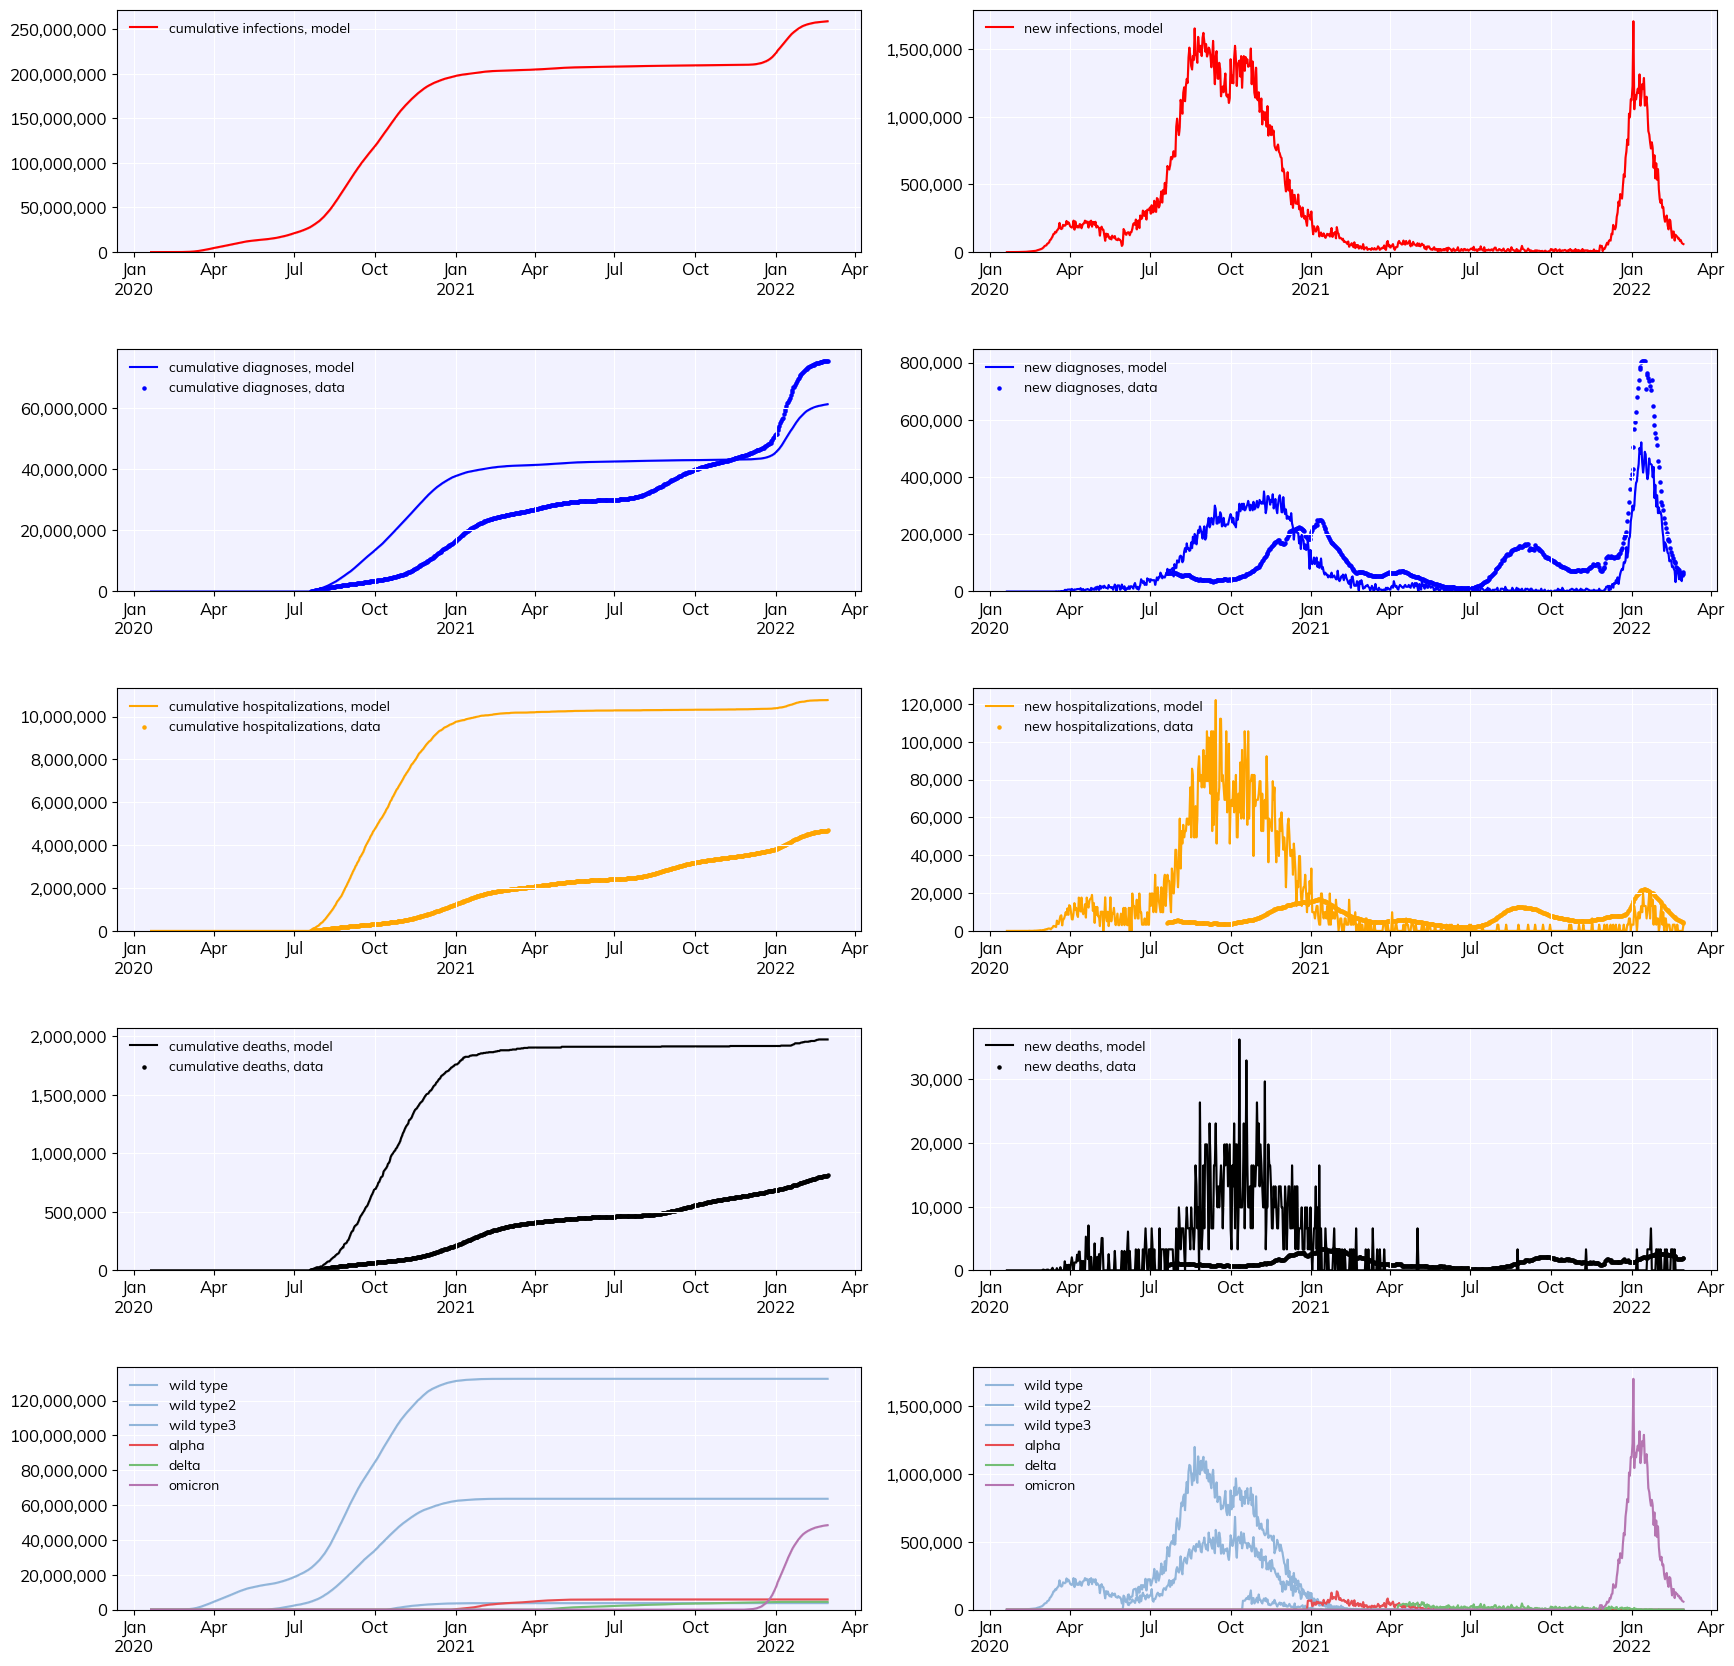

In [ ]:
# 20% tests counterfactual
# note: this is just ONE RUN, no replicates here, so no "support intervals" in fig
# this takes ~2min on mac laptop
# analyzer for nabs added
s1 = make_sim(
    beta=0.016, 
    pop_infected=1000, #1000,
    N_AGENTS=100_000, #100_000,
    people_per_agent=3300, #3300,
    start_day='2020-01-20',
    end_day='2022-03-01', 
    seed=30, # this gets changed for each replicate
    data_path='data/usa-data-1.0-0.2.csv',
    mappers_path='data/mappers-1.0.joblib',
    verbose=0.1, 
    analyzers=[store_doses(label='doses')]
)

print("made s1...")

task_id = 1 ## tmp fix

s1['rand_seed'] = task_id
s1.set_seed()
s1.label = f"Sim_{task_id}"
print(f"set s1 rand seed to {task_id}...")

s1.run()

msim1 = cv.MultiSim([s1])
msim1.mean()

custom_plot(msim1)

#### explaining the shape of counterfactuals C1 and C2
* above, we've just run C1 once, illustrates the general finding of both counterfactuals
* for cumulative hospitalization & death:
    * there is a rapid rise, from July 2020 thru about Jan 2021,
    * followed by plateauing (actually, there is ongoing slow increase, but looks pretty flat)
* believe this can be explained by the fraction of simulated population with neutralizing antibodies to C19
    * neutralizing abs (nabs) can come either from 1) prior infection or 2) from vaccination
    * below, we first plot fraction vaccinated over time, to show when "the vaccination effect" contributes to nabs
* as shown in 2nd fig below, in Jan 2021, 
    * only about 10% of popn has nabs in the model calibrated to historical data
    * in contrast, over 50% of popn has nabs in counterfactual C1
* from Jan 2021 to Jun 2021, there's fewer new cases, but vaccination adds to overall nabs in population
    * in Jun 2021, about 55% of popn has nabs in model calibrated to historical data
    * in Jun 2021, about 75% of popn has nabs in counterfactual C1
* another part of C1 appearing to be a plateau after Jan 2021 is scale artifact
    * see 3rd fig below
* together, these seem to be plausible explanations for:
    * very limited, slow rise in cumulative hosp / deaths in C1 & C2 after Jan 2021
    * more steady rise in cumulative hosp / deaths, punctuated by waves of rapid increase, when using 'real data'

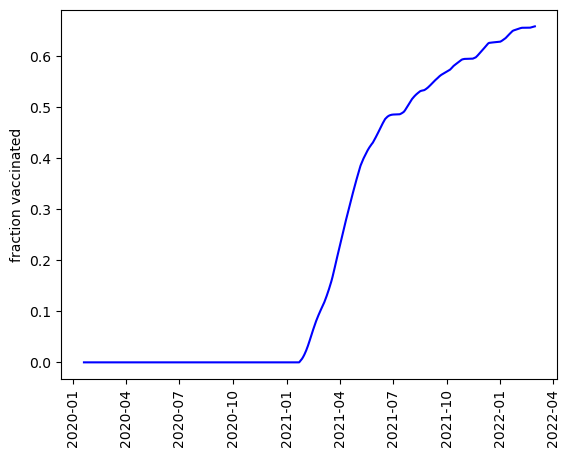

In [ ]:
# fraction vaccinated -- rapid steady climb from 1/15/21 to about 6/15/21, followed by
# more gradual increase
plt.plot(s0.results['date'], s0.results['frac_vaccinated'], color='blue')
plt.ylabel('fraction vaccinated')
plt.xticks(rotation=90)
plt.show()

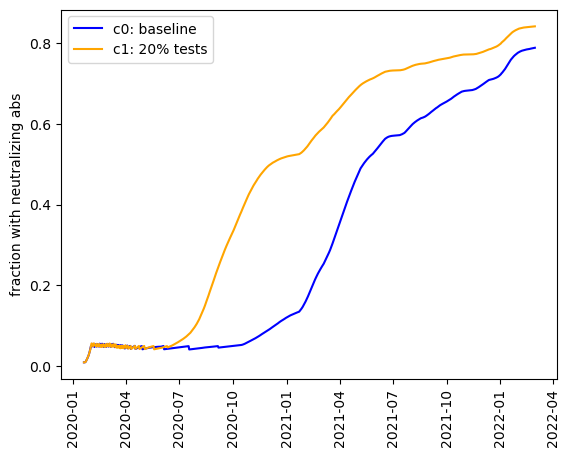

In [ ]:
# retrieve neutralizing antibody analyzers from sims for plot below
nab0 = s0.get_analyzer('nab')
nab1 = s1.get_analyzer('nab')

# below illustrates why counterfactuals c1 and c2 rise to plateau and do not increase much after --
# considering both 1) first wave being much worse and 2) vaccination, c1 agents get to ~75% with nabs by 7/1/21,
# while c1 is only about 55-60% nabs at that point; c0 only gets close to 75% at omicron...
# recall from vaccination plot that from 1/15/21 to about 6/15/21, much of increase in frac with nabs
# is from vaccination, and even gradually therafter until 1/1/22; steeper increases in blue line after
# 7/1/21 probably imply significant number of new infections in addition to vaccinations.
fig, ax = plt.subplots()

ax.plot(s0.results['date'], np.array(nab0.ct_ppl_nabs) / 100_000, label='c0: baseline', color='blue')
ax.plot(s0.results['date'], np.array(nab1.ct_ppl_nabs) / 100_000, label='c1: 20% tests', color='orange')
ax.set_ylabel('fraction with neutralizing abs')

plt.xticks(rotation=90)
plt.legend()


plt.show()


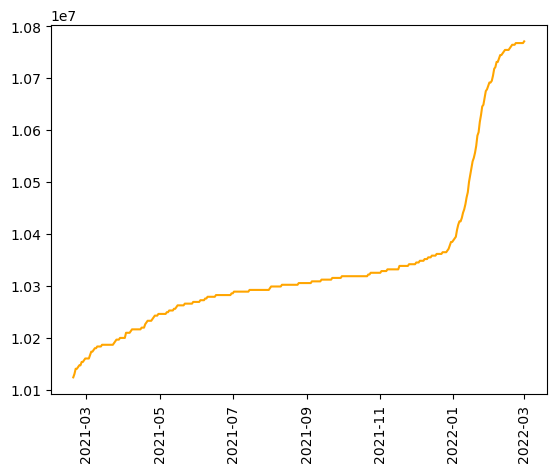

In [ ]:
# below shows that some of apparent plateauing in C1 is artifact of scale --
# we can 'zoom in' on cumulative hospitalization curve on just the "plateau" part from Jan 2021 - March 2022
# when we zoom in, we can see clearly the ongoing increase, with surges associated with alpha & omicron
fig, ax = plt.subplots()

dt_idx = 180 # this is index for date we use to derive subtract off values
                
feature = 'cum_severe'

# initialize subtract off values (these will stay 0 for any 'non-cumulative' feature)
model_subtract_off, data_subtract_off = 0, 0

if feature == 'cum_severe' or feature == 'cum_deaths' or feature == 'cum_diagnoses':
    # index 181 corresponds to 7/20
    model_subtract_off = msim1.results[feature].values[dt_idx]
    data_subtract_off = msim1.sims[0].data[feature].values[dt_idx]
    if np.isnan(data_subtract_off):
        data_subtract_off = 0

color = 'orange'
label = 'cumulative hospitalizations, model'
# plot model predictions
ax.plot(
    msim1.results['date'][395:], 
    # msim.results[feature].values
    np.maximum(msim1.results[feature].values[395:]-model_subtract_off, 0),
    color=color, 
    label=label
)
plt.xticks(rotation=90)
plt.show()